In [1]:
# import libaries

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, ReLU6, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
from statistics import mean

import datetime
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from mtcnn import MTCNN
import cv2
 


In [199]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda:0"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Mon Apr 10 14:36:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   49C    P8    28W / 175W |   1578Mi

In [3]:
seed = 41
img_size = 112

In [252]:
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, df, train, num_sample = None, transform = None, num_img_pool = 20, ):
        # set random seed for FaceDataset
        np.random.seed(seed)
        random.seed(seed)
        # create constructors
        self.unique_img_name = None
        self.train = train
        self.data = dict()
        self.images = list()
        self.identities = list()
        # label to indices
        # self.label_to_indices = dict()
        self.labels = list()
        self.img_name = list()
        # read csv file
        self.df = df
        # set the transformation
        self.transform = transform
        # drop last n row from dataframe
        self.df = self.df.head(num_sample)
        #get the length of entire dataset
        self.len_ = len(self.df)
        if num_sample is None or num_sample > self.len_:
            num_sample = self.len_
        # load imgs
        self.load_imgs(self.df, num_imgs = num_img_pool, max = num_sample)

    def __len__(self):
        return self.len_

    def __getitem__(self, idx):
        if self.train:
            anchor_img = Image.open(self.images[idx]).convert('RGB')
            anchor_label = self.labels[idx]
            pos_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
            neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

            pos_img = Image.open(self.images[pos_idx]).convert('RGB')
            neg_img = Image.open(self.images[neg_idx]).convert('RGB')

            pos_label = self.labels[pos_idx]
            neg_label = self.labels[neg_idx]

            if self.transform is None:
                img_to_tensor = transforms.ToTensor()
                anchor_img = img_to_tensor(anchor_img)
                pos_img = img_to_tensor(pos_img)
                neg_img = img_to_tensor(neg_img)
            else:
                anchor_img = self.transform(anchor_img)
                pos_img = self.transform(pos_img)
                neg_img = self.transform(neg_img)
            return anchor_img, pos_img, neg_img

        else:
            label = False
            anchor_img = Image.open(self.images[idx]).convert('RGB')
            anchor_label = self.labels[idx]
            if idx % 2 == 0:
                test_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
                label = True

            else:
                test_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

            neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])
            test_img = Image.open(self.images[test_idx]).convert('RGB')
            neg_img = Image.open(self.images[neg_idx]).convert('RGB')

            if self.transform is None:
                img_to_tensor = transforms.ToTensor()
                anchor_img = img_to_tensor(anchor_img)
                test_img = img_to_tensor(test_img)
                neg_img = img_to_tensor(neg_img)

            else:
                anchor_img = self.transform(anchor_img)
                test_img = self.transform(test_img)
                neg_img = self.transform(neg_img)

            return anchor_img, test_img, neg_img ,label, self.identities[idx], self.img_name[idx], self.identities[test_idx], self.img_name[test_idx]

    # load imgs from pandas to memory and define the maximum number of images
    def load_imgs(self, df, num_imgs, max):
        # iterate thought each row
        for i, row in tqdm(df.iterrows(), total = max):
            # get identity of each row
            row_identity = row['identity']
            # append each identity to numberical value
            # self.label_to_indices[int(row_identity)] = i
            count_img = 0
            # loop imgs in each identity
            for img_name in row['path']:
#                 if count_img > num_imgs:
#                     break
                # concatenate the directoru and image name
                # path_to_image = self.dir+img_name
                path_to_image = img_name
                # open image and convert to RGB
#                 img = Image.open(path_to_image).convert('RGB')
                self.labels.append(i)
                self.images.append(path_to_image)
                
                self.img_name.append(path_to_image)
                self.identities.append(str(row_identity))
                
                count_img += 1  # print('Added img '+ str(row_identity))
        self.labels = np.array(self.labels)
    

In [234]:
# ds_df = pd.read_csv('./csv_files/vgg_face.csv')
ds_df = pd.read_csv('./csv_files/combine_2_df.csv')
# ds_df = pd.read_csv('./digiface_csv_files/digi_all.csv')
# ds_df = pd.read_csv('./csv_files/lfw_ds.csv')
ds_df = ds_df.groupby('identity')['path'].apply(list).reset_index()
ds_df

C:\Users\pie31\AppData\Local\Temp/ipykernel_17320/2433586835.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ds_df = pd.read_csv('./csv_files/combine_2_df.csv')


identity                                               path
0           90  [./digiFace1M/subjects_0-1999_72_imgs\90\57.pn...
1           91  [./digiFace1M/subjects_0-1999_72_imgs\91\10.pn...
2           92  [./digiFace1M/subjects_0-1999_72_imgs\92\0.png...
3           93  [./digiFace1M/subjects_0-1999_72_imgs\93\0.png...
4           94  [./digiFace1M/subjects_0-1999_72_imgs\94\0.png...
...        ...                                                ...
79943  n007468  [./vggface2_224/n007468\0001_01.jpg, ./vggface...
79944  n007469  [./vggface2_224/n007469\0001_01.jpg, ./vggface...
79945  n007470  [./vggface2_224/n007470\0001_01.jpg, ./vggface...
79946  n007471  [./vggface2_224/n007471\0001_02.jpg, ./vggface...
79947  n007472  [./vggface2_224/n007472\0001_01.jpg, ./vggface...

[79948 rows x 2 columns]

In [235]:

# splitting each dataset
# train_df, eval_df = train_test_split(ds_df, test_size = 0.3, shuffle = True, random_state = seed)
# val_df, test_df = train_test_split(eval_df, test_size = 0.4, shuffle = True, random_state = seed)
train_df, val_df = train_test_split(ds_df, test_size = 0.2, shuffle = True, random_state = seed)

# print to check size of each dataset
print(f'Train Size: {len(train_df)}')
print(f'Val Size: {len(val_df)}')
# print(f'Test Size: {len(test_df)}')

train_df.head(5)

Train Size: 63958
Val Size: 15990


identity                                               path
55606   184891  [./digiFace1M/subjects_166666-199998_5_imgs\18...
20198   116094  [./digiFace1M/subjects_100000-133332_5_imgs\11...
15035   110925  [./digiFace1M/subjects_100000-133332_5_imgs\11...
37554   166813  [./digiFace1M/subjects_166666-199998_5_imgs\16...
69068   198374  [./digiFace1M/subjects_166666-199998_5_imgs\19...

In [236]:
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class h_sigmoid(Module):
    def __init__(self, inplace = True):
        super(h_sigmoid, self).__init__()
        self.relu = ReLU6(inplace = inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(Module):
    def __init__(self, inplace = True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace = inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(Module):
    def __init__(self, channel, reduction = 4):
        super(SELayer, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc = Sequential(Linear(channel, channel // reduction), ReLU(inplace = True),
                             Linear(channel // reduction, channel), h_sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class PermutationBlock(Module):
    def __init__(self, groups):
        super(PermutationBlock, self).__init__()
        self.groups = groups

    def forward(self, input):
        n, c, h, w = input.size()
        G = self.groups
        output = input.view(n, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(n, c, h, w)
        return output


class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x


class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Depth_Wise(Module):
    def __init__(self, in_c, out_c, residual = False, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c = groups, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.conv_dw = Conv_block(groups, groups, groups = groups, kernel = kernel, padding = padding, stride = stride)
        self.project = Linear_block(groups, out_c, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.residual = residual

    def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output


class Residual(Module):
    def __init__(self, c, num_block, groups, kernel = (3, 3), stride = (1, 1), padding = (1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(
                Depth_Wise(c, c, residual = True, kernel = kernel, padding = padding, stride = stride, groups = groups))
        self.model = Sequential(*modules)

    def forward(self, x):
        return self.model(x)


class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start = start_value, stop = stop_value, num = nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1


class DropBlock2D(nn.Module):

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input = mask[:, None, :, :], kernel_size = (
            self.block_size, self.block_size), stride = (1, 1), padding = self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


In [237]:
class MobileFaceNet(Module):
    def __init__(self, embedding_size = 512):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel = (3, 3), stride = (1, 1), padding = (1, 1), groups = 64)
        self.conv_23 = Depth_Wise(64, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 128)
        self.conv_3 = Residual(64, num_block = 4, groups = 128, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 256)
        self.conv_4 = Residual(128, num_block = 6, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 512)
        self.conv_5 = Residual(128, num_block = 2, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel = (1, 1), stride = (1, 1), padding = (0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups = 512, kernel = (7, 7), stride = (1, 1), padding = (0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias = False)
        self.bn = BatchNorm1d(embedding_size)
        self.dropblock = DropBlock2D(block_size = 3, drop_prob = 0.3)
        self.dropout = Dropout(0.1)

    def forward_once(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)
        
        out = self.dropblock(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.dropblock(out)

        out = self.conv_6_dw(out)

        out = self.dropblock(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)

        return l2_norm(out)

    def forward(self, img):
        anchor = self.forward_once(img)
        return anchor

In [238]:
triplet_model = MobileFaceNet()
print(summary(triplet_model, input_size = [(32, 3, 112, 112)]))

Layer (type:depth-idx)                        Output Shape              Param #
MobileFaceNet                                 [32, 512]                 --
├─Conv_block: 1-1                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-1                            [32, 64, 56, 56]          1,728
│    └─BatchNorm2d: 2-2                       [32, 64, 56, 56]          128
│    └─PReLU: 2-3                             [32, 64, 56, 56]          64
├─Conv_block: 1-2                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-4                            [32, 64, 56, 56]          576
│    └─BatchNorm2d: 2-5                       [32, 64, 56, 56]          128
│    └─PReLU: 2-6                             [32, 64, 56, 56]          64
├─Depth_Wise: 1-3                             [32, 64, 28, 28]          --
│    └─Conv_block: 2-7                        [32, 128, 56, 56]         --
│    │    └─Conv2d: 3-1                       [32, 128, 56, 56]         8,192
│    │    └

In [239]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average = True):
        # calculate Euclidean's distance
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)

        losses = F.relu(distance_positive - distance_negative + self.margin)

        return torch.mean(losses)
    
# def double_triplet_loss(nn.Module): 
    

In [240]:
def calculate_accuracy(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else float(true_positives) / float(
        true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else float(false_positives) / float(
        false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else float(true_positives) / float(
        true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else float(true_positives) / float(
        true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    #     return true_positive_rate, false_positive_rate, precision, recall, accuracy
    return [true_positive_rate, false_positive_rate, accuracy]

# save the model weight
def save_weight(custom_name: str, model, csv_file: str):
    # check csv file exist 
    if not os.path.exists(csv_file):
        # create new csv_file
        pd.DataFrame(columns = ['date_added', 'path']).to_csv(csv_file)
    # read csv file    
    weight_df = pd.read_csv(csv_file)

    datetime_now = str(datetime.datetime.now())
    save_path = './weights/' + custom_name + datetime_now[:-7].replace('-', '').replace(':', '') + '.pth'

    # create dataframe
    temp_df = pd.DataFrame([[datetime_now, save_path]], columns = ['date_added', 'path'])
    weight_df = pd.concat([weight_df, temp_df], axis = 0, ignore_index = True).drop(['Unnamed: 0'], axis = 1)
    weight_df = weight_df[['date_added', 'path']]
    # save csv 
    weight_df.to_csv(csv_file)
    # save weight 
    save_weight_path = save_path
    torch.save(model.state_dict(), save_weight_path)
    print('Save Success! @' + datetime_now + ' in ' + save_path)
    return save_path


# get the latest weight
def get_latest_weight(csv_path: str) -> str:
    # read csv file
    weight_df = pd.read_csv(csv_path)
    # convert object to datetime type
    weight_df['date_added'] = pd.to_datetime(weight_df['date_added'])
    # sorting date
    weight_df = weight_df.sort_values(by = 'date_added', ascending = False)
    # get latest item
    latest_record = weight_df.head(1)
    print('It was saved at ' + str(latest_record['date_added'].values[0]))
    return weight_df['path'].head(1).values[0]

In [241]:
def train_model(model, train_loader, train_optimizer, train_criterion, weight_path = None):
    train_loss = 0
    train_accuracy = list()
    label_s = list()
    # applied weight
    if weight_path != None:
        model.load_state_dict(weight_path)
    # set to train mode
    model.train()
    # loop though loader
    with torch.set_grad_enabled(True):
        for anchor_img, pos_img, neg_img in tqdm(train_loader):
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)

            # throw img to CUDA
            anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)

            # training model
            # anchor_img, pos_img, neg_img = model(anchor_img, pos_img,neg_img)
            anchor_out = model(anchor_img)
            pos_out = model(pos_img)
            neg_out = model(neg_img)
            # calculate distances 
            pos_dists = (anchor_out - pos_out).pow(2).sum(1)
            neg_dists = (anchor_out - neg_out).pow(2).sum(1)
            
            # triplet selections
#             if False: 
#                 first_condition = (neg_dists - pos_dists < model_config['threshold']).cpu().numpy().flatten()
#                 second_condition = (pos_dists < neg_dists).cpu().numpy().flatten()
#                 all = (np.logical_and(first_condition, second_condition))
#                 valid_triplets = np.where(all == 1)
#             else: 
#                 all = (neg_dists - pos_dists < model_config['threshold']).cpu().numpy().flatten()
#                 valid_triplets = np.where(all == 1)
            # calculate loss
            loss = train_criterion(anchor_out, pos_out, neg_out)
            # prevent grad vansishing
            train_optimizer.zero_grad()
            # backpropragation
            loss.backward()
            # compute gradient
            train_optimizer.step()
            # compute train loss
            train_loss += loss.item() * anchor_img.size(0)
    # test_acc, distances, labels =test_model(model, train_loader)

    return train_loss


def test_model(model, test_loader,train_criterion, weight_path: str = None):
    
    test_accuracy = list()
    label_s = list()
    distance_s = list()
    distances_hist = list()
    
    test_imgs_name = list()
    anch_imgs_name = list()
    
    test_identities = list()
    anch_identities = list()
    
    test_loss = 0
    if weight_path is not None:
        model.load_state_dict(torch.load(weight_path))
        print('Weight loaded!')
    # set to train mode
    model.eval()
    # enable grad
    with torch.no_grad():
        # loop though loader
        #anchor_img, test_img, neg_img ,label, self.identities[idx], self.img_name[idx], self.identities[test_idx], self.img_name[test_idx], 

        for index, (anchor_img, test_img, neg_img, label, anch_iden, anch_name, test_iden, test_name) in enumerate(test_loader):
            
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)
            # throw img to CUDA
            anchor_img, test_img, neg_img = anchor_img.to(device), test_img.to(device), neg_img.to(device)
            # compute distance from model
            anchor_out = model(anchor_img)
            test_out = model(test_img)
            neg_out = model(neg_img)
            # calculate loss
            loss = train_criterion(anchor_out,test_out,neg_out)
            # calculate distance between anchor and test images
            distance_val = (anchor_out - test_out).pow(2).sum(1)
            # append label coordinate with each testing pair
            label_s.append(label.cpu().data.numpy())
            distance_s.append(distance_val.cpu().data.numpy())
            test_loss += loss.item() * anchor_img.size(0)
            
            test_imgs_name.append(test_name)
            anch_imgs_name.append(anch_name)
            test_identities.append(test_iden)
            anch_identities.append(anch_iden)
            
        labels_hist = [sub_label for each_label in label_s for sub_label in each_label]
        distance_hist = [sub_distance for each_distance in distance_s for sub_distance in each_distance]
        
        test_imgs_name = [sub for each in test_imgs_name for sub in each]
        anch_imgs_name = [sub for each in anch_imgs_name for sub in each]
        test_identities = [sub for each in test_identities for sub in each]
        anch_identities = [sub for each in anch_identities for sub in each]
        
        test_accuracy.append(calculate_accuracy(np.full(np.size(distance_hist),
                                                        model_config['margin']), np.array(distance_hist), labels_hist)[
                                 2])
    return mean(test_accuracy), distance_hist, labels_hist, test_loss, anch_imgs_name, test_imgs_name, test_identities, anch_identities


In [254]:
# define transformation for test set
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.CenterCrop((img_size,img_size)),
                                      transforms.RandomHorizontalFlip(p = 0.6),
                                      transforms.RandomRotation(degrees=5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.5, 0.5, 0.5],
                                                           std = [0.5, 0.5, 0.5])
                                      ])
# define transformation for validation set
val_transform = transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.CenterCrop((img_size,img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                                                           std = [0.5, 0.5, 0.5])
                                    ])

cross_val_train_dataset = FaceDataset(df = train_df, train = True, num_sample = 15000, transform = train_transform)
cross_val_val_dataset = FaceDataset(df = val_df, train = False, num_sample = 3000, transform = val_transform)
train_batch_size = 64
val_batch_size = 64

train_triplet_dataloader = DataLoader(cross_val_train_dataset, batch_size = train_batch_size, shuffle = True,
                                      pin_memory = True)
val_triplet_dataloader = DataLoader(cross_val_val_dataset, batch_size = val_batch_size, shuffle = True,
                                    pin_memory = True)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [250]:
model_config = {
    'margin': 0.98,
    'lr': 1e-3,
    'patience': 5,
    'factor': 0.1,
    'min_lr': 1e-10,
    'threshold': 1e-3
    }
criterion = TripletLoss(margin = model_config['margin'])
optimizer = optim.Adam(triplet_model.parameters(), lr = model_config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = model_config['patience'],
                                                 factor = model_config['factor'], min_lr = model_config['min_lr'],
                                                 threshold = model_config['threshold'], verbose = True)

In [255]:
num_epoch = 120
previous_lr = 0
hist_epoch_train_loss = list()
hist_epoch_val_loss = list()
hist_epoch_train_acc = list()
hist_epoch_val_acc = list()
# latest_weight_path = get_latest_weight('./csv_files/weight_records.csv')

triplet_model = MobileFaceNet().to(device)

for epoch in tqdm(range(num_epoch)):
    
    # train model
    epoch_train_loss = train_model(triplet_model, train_triplet_dataloader, optimizer, criterion)
    # validate model
    epoch_val_acc, epoch_distances, epoch_labels, epoch_val_loss,_,_,_,_ = test_model(triplet_model, val_triplet_dataloader, criterion)
   
    # compute loss
    train_loss = epoch_train_loss / len(train_triplet_dataloader.sampler)
    val_loss = epoch_val_loss / len(val_triplet_dataloader.sampler)
    # update scheduler
    scheduler.step(train_loss)

    hist_epoch_train_loss.append(train_loss)
    hist_epoch_val_acc.append(epoch_val_acc)
    hist_epoch_val_loss.append(val_loss)
    # get the learning rate
    optim_lr = optimizer.param_groups[0]['lr']
    if (optim_lr < previous_lr) | (optim_lr > previous_lr):
        print('LEARNING RATE HAS CHANGED!')
    # update learning rate to temp variable
    previous_lr = optim_lr
    # observe status
    print(
        f' Epoch {epoch + 1}/{num_epoch},Learning rate: {optim_lr}, train loss: {round(train_loss, 5)},val loss: {round(val_loss,5)}, val acc: {round(epoch_val_acc, 5)}')
save_path = save_weight(custom_name = 'mobile_network_120_updated', model = triplet_model,
                        csv_file = './csv_files/weight_records.csv')


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
 Epoch 1/120,Learning rate: 0.001, train loss: 0.95051,val loss: 0.91489, val acc: 0.524


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 2/120,Learning rate: 0.001, train loss: 0.94782,val loss: 0.91584, val acc: 0.521


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 3/120,Learning rate: 0.001, train loss: 0.94793,val loss: 0.91898, val acc: 0.52167


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 4/120,Learning rate: 0.001, train loss: 0.94943,val loss: 0.90734, val acc: 0.52467


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 5/120,Learning rate: 0.001, train loss: 0.94972,val loss: 0.91566, val acc: 0.52333


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 6/120,Learning rate: 0.001, train loss: 0.94662,val loss: 0.91647, val acc: 0.53033


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 7/120,Learning rate: 0.001, train loss: 0.95096,val loss: 0.91406, val acc: 0.52333


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 8/120,Learning rate: 0.001, train loss: 0.95179,val loss: 0.9191, val acc: 0.527


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 9/120,Learning rate: 0.001, train loss: 0.95095,val loss: 0.9061, val acc: 0.529


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 10/120,Learning rate: 0.001, train loss: 0.94848,val loss: 0.91366, val acc: 0.523


  0%|          | 0/235 [00:00<?, ?it/s]

 Epoch 11/120,Learning rate: 0.001, train loss: 0.94902,val loss: 0.90607, val acc: 0.52433


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
 Epoch 12/120,Learning rate: 0.0001, train loss: 0.947,val loss: 0.91976, val acc: 0.521


  0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(1, len(hist_epoch_train_loss) + 1), hist_epoch_train_loss, label = 'Train Loss')
plt.plot(np.arange(1, len(hist_epoch_val_loss) + 1), hist_epoch_val_loss, label = 'Val Loss')
plt.plot(np.arange(1, len(hist_epoch_val_acc) + 1), hist_epoch_val_acc, label = 'Validation acc')
plt.legend()
plt.show()

# Cross Validation

In [17]:
num_epoch = 130
previous_lr = 0
history_train = {
    'train_loss': dict(),
    'val_loss': dict(),
    'train_acc': dict(),
    'val_acc': dict()
    }
split = 5
k_fold = KFold(n_splits = split, shuffle = True, random_state = seed)
batch_size = 64
for fold, (train_idx, valid_idx) in tqdm(enumerate(k_fold.split(cross_val_train_dataset)), total = split):
    triplet_model = MobileFaceNet()

    triplet_model.to(device)
    
    criterion = TripletLoss(margin = model_config['margin'])
    optimizer = optim.Adam(triplet_model.parameters(), lr = model_config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = model_config['patience'], factor =
    model_config['factor'], min_lr = model_config['min_lr'], threshold = model_config['threshold'], verbose = True)
    print(f'Fold: {fold}/{split}')

    # the number of epoch in each fold
    # Random get the sample from dataset
    train_subsampler = torch.utils.data.Subset(cross_val_train_dataset, train_idx)
    valid_subsampler = torch.utils.data.Subset(cross_val_val_dataset, valid_idx)

    # Load data into dataloader
    train_loader = DataLoader(train_subsampler, batch_size = batch_size, shuffle = True, pin_memory = True)
    valid_loader = DataLoader(valid_subsampler, batch_size = batch_size, shuffle = True, pin_memory = True)

    hist_epoch_train_loss = list()
    hist_epoch_val_loss = list()
    hist_epoch_val_acc = list()

    for epoch in tqdm(range(num_epoch)):
        # train model
        epoch_train_loss = train_model(triplet_model, train_loader, optimizer, criterion)
        # validate model
        epoch_val_acc, epoch_distances, epoch_labels,epoch_val_loss,_,_,_,_ = test_model(triplet_model, val_triplet_dataloader, criterion)

       # compute loss
        train_loss = epoch_train_loss / len(train_triplet_dataloader.sampler)
        val_loss = epoch_val_loss / len(val_triplet_dataloader.sampler)
        # update scheduler
        scheduler.step(train_loss)

        hist_epoch_train_loss.append(train_loss)
        hist_epoch_val_acc.append(epoch_val_acc)
        hist_epoch_val_loss.append(val_loss)
    

        # get the learning rate
        optim_lr = optimizer.param_groups[0]['lr']
        if (optim_lr < previous_lr) | (optim_lr > previous_lr):
            print('LEARNING RATE HAS CHANGED!')
        # update learning rate to temp variable
        previous_lr = optim_lr
        # observe status
        print(f'Fold: {fold + 1}/{split}, Epoch {epoch + 1}/{num_epoch},Learning rate: {optim_lr}, train loss: {round(train_loss, 5)}, \val loss: {round(val_loss, 5)}, val acc: {round(epoch_val_acc, 5)}')

    # append historical data
    history_train['train_loss'][fold] = hist_epoch_train_loss
    history_train['val_acc'][fold] = hist_epoch_val_acc
    history_train['val_loss'][fold] = hist_epoch_val_loss

    print(f'Average result {fold + 1}/{split}, Avg train loss:', mean(history_train['train_loss'][fold]),'avg val loss:', mean(history_train['val_loss'][fold]),  'avg val acc:', mean(history_train['val_acc'][fold]))
    # clear GPU memory allocated
    torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

Fold: 0/5


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.61488, al loss: 0.83602, val acc: 0.69667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.50186, al loss: 0.71554, val acc: 0.72


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.46184, al loss: 0.75331, val acc: 0.76333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.42535, al loss: 0.71736, val acc: 0.74333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.40566, al loss: 0.74789, val acc: 0.78667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.38002, al loss: 0.62619, val acc: 0.8


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.37065, al loss: 0.71644, val acc: 0.77667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.35562, al loss: 0.69115, val acc: 0.81667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 9/130,Learning rate: 0.001, train loss: 0.34514, al loss: 0.7273, val acc: 0.78


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 10/130,Learning rate: 0.001, train loss: 0.33718, al loss: 0.76122, val acc: 0.79667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 11/130,Learning rate: 0.001, train loss: 0.31367, al loss: 0.71743, val acc: 0.78


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 12/130,Learning rate: 0.001, train loss: 0.3133, al loss: 0.64315, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 13/130,Learning rate: 0.001, train loss: 0.30708, al loss: 0.73581, val acc: 0.8


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 14/130,Learning rate: 0.001, train loss: 0.29209, al loss: 0.68452, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 15/130,Learning rate: 0.001, train loss: 0.28239, al loss: 0.59933, val acc: 0.84667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 16/130,Learning rate: 0.001, train loss: 0.29116, al loss: 0.65221, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 17/130,Learning rate: 0.001, train loss: 0.27568, al loss: 0.67302, val acc: 0.81667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 18/130,Learning rate: 0.001, train loss: 0.27727, al loss: 0.64771, val acc: 0.81


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 19/130,Learning rate: 0.001, train loss: 0.26395, al loss: 0.64874, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 20/130,Learning rate: 0.001, train loss: 0.25659, al loss: 0.65126, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 21/130,Learning rate: 0.001, train loss: 0.25774, al loss: 0.66702, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 22/130,Learning rate: 0.001, train loss: 0.24381, al loss: 0.59409, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 23/130,Learning rate: 0.001, train loss: 0.24698, al loss: 0.67575, val acc: 0.85333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 24/130,Learning rate: 0.001, train loss: 0.23485, al loss: 0.56284, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 25/130,Learning rate: 0.001, train loss: 0.24195, al loss: 0.6501, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 26/130,Learning rate: 0.001, train loss: 0.23629, al loss: 0.60778, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 27/130,Learning rate: 0.001, train loss: 0.23205, al loss: 0.58985, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 28/130,Learning rate: 0.001, train loss: 0.22182, al loss: 0.62743, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 29/130,Learning rate: 0.001, train loss: 0.21978, al loss: 0.67735, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 30/130,Learning rate: 0.001, train loss: 0.22149, al loss: 0.62474, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 31/130,Learning rate: 0.001, train loss: 0.21867, al loss: 0.61425, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 32/130,Learning rate: 0.001, train loss: 0.21082, al loss: 0.60968, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 33/130,Learning rate: 0.001, train loss: 0.21288, al loss: 0.61429, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 34/130,Learning rate: 0.001, train loss: 0.20799, al loss: 0.63981, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 35/130,Learning rate: 0.001, train loss: 0.21561, al loss: 0.62336, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 36/130,Learning rate: 0.001, train loss: 0.20708, al loss: 0.60118, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 37/130,Learning rate: 0.001, train loss: 0.20418, al loss: 0.58968, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 38/130,Learning rate: 0.001, train loss: 0.19926, al loss: 0.68745, val acc: 0.84333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 39/130,Learning rate: 0.001, train loss: 0.19963, al loss: 0.61753, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 40/130,Learning rate: 0.001, train loss: 0.20721, al loss: 0.63715, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 41/130,Learning rate: 0.001, train loss: 0.20413, al loss: 0.63587, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 42/130,Learning rate: 0.001, train loss: 0.19215, al loss: 0.58081, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 43/130,Learning rate: 0.001, train loss: 0.20216, al loss: 0.5967, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 44/130,Learning rate: 0.001, train loss: 0.18782, al loss: 0.63713, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 45/130,Learning rate: 0.001, train loss: 0.20076, al loss: 0.56562, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 46/130,Learning rate: 0.001, train loss: 0.18537, al loss: 0.61501, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 47/130,Learning rate: 0.001, train loss: 0.18814, al loss: 0.61397, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 48/130,Learning rate: 0.001, train loss: 0.19243, al loss: 0.55411, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 49/130,Learning rate: 0.001, train loss: 0.18455, al loss: 0.57843, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 50/130,Learning rate: 0.001, train loss: 0.17364, al loss: 0.6063, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 51/130,Learning rate: 0.001, train loss: 0.18496, al loss: 0.67495, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 52/130,Learning rate: 0.001, train loss: 0.18078, al loss: 0.58509, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 53/130,Learning rate: 0.001, train loss: 0.182, al loss: 0.61637, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 54/130,Learning rate: 0.001, train loss: 0.18401, al loss: 0.58339, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 55/130,Learning rate: 0.001, train loss: 0.17957, al loss: 0.59725, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00056: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 56/130,Learning rate: 0.0001, train loss: 0.18434, al loss: 0.55368, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 57/130,Learning rate: 0.0001, train loss: 0.1623, al loss: 0.5973, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 58/130,Learning rate: 0.0001, train loss: 0.16023, al loss: 0.56555, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 59/130,Learning rate: 0.0001, train loss: 0.16075, al loss: 0.65015, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 60/130,Learning rate: 0.0001, train loss: 0.16039, al loss: 0.59059, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 61/130,Learning rate: 0.0001, train loss: 0.15105, al loss: 0.60368, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 62/130,Learning rate: 0.0001, train loss: 0.14677, al loss: 0.60204, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 63/130,Learning rate: 0.0001, train loss: 0.1534, al loss: 0.61234, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 64/130,Learning rate: 0.0001, train loss: 0.14767, al loss: 0.56774, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 65/130,Learning rate: 0.0001, train loss: 0.14748, al loss: 0.60035, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 66/130,Learning rate: 0.0001, train loss: 0.14431, al loss: 0.57632, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 67/130,Learning rate: 0.0001, train loss: 0.14621, al loss: 0.54562, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 68/130,Learning rate: 0.0001, train loss: 0.14392, al loss: 0.61742, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 69/130,Learning rate: 0.0001, train loss: 0.1481, al loss: 0.56131, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 70/130,Learning rate: 0.0001, train loss: 0.14762, al loss: 0.58748, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 71/130,Learning rate: 0.0001, train loss: 0.13824, al loss: 0.5682, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 72/130,Learning rate: 0.0001, train loss: 0.14265, al loss: 0.58759, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 73/130,Learning rate: 0.0001, train loss: 0.14184, al loss: 0.61038, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 74/130,Learning rate: 0.0001, train loss: 0.14504, al loss: 0.56808, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 75/130,Learning rate: 0.0001, train loss: 0.14623, al loss: 0.63315, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 76/130,Learning rate: 0.0001, train loss: 0.1332, al loss: 0.57504, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 77/130,Learning rate: 0.0001, train loss: 0.13595, al loss: 0.59188, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 78/130,Learning rate: 0.0001, train loss: 0.14149, al loss: 0.54798, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 79/130,Learning rate: 0.0001, train loss: 0.14208, al loss: 0.63637, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 80/130,Learning rate: 0.0001, train loss: 0.13959, al loss: 0.61446, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 81/130,Learning rate: 0.0001, train loss: 0.1373, al loss: 0.55659, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00082: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 82/130,Learning rate: 1e-05, train loss: 0.14161, al loss: 0.58567, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 83/130,Learning rate: 1e-05, train loss: 0.14002, al loss: 0.57642, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 84/130,Learning rate: 1e-05, train loss: 0.1438, al loss: 0.57468, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 85/130,Learning rate: 1e-05, train loss: 0.13558, al loss: 0.57518, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 86/130,Learning rate: 1e-05, train loss: 0.13945, al loss: 0.552, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 87/130,Learning rate: 1e-05, train loss: 0.13813, al loss: 0.54839, val acc: 0.94667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00088: reducing learning rate of group 0 to 1.0000e-06.
LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 88/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13784, al loss: 0.57554, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 89/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13454, al loss: 0.59763, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 90/130,Learning rate: 1.0000000000000002e-06, train loss: 0.139, al loss: 0.54489, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 91/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13963, al loss: 0.59169, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 92/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13801, al loss: 0.61201, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 93/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13501, al loss: 0.57358, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00094: reducing learning rate of group 0 to 1.0000e-07.
LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 94/130,Learning rate: 1.0000000000000002e-07, train loss: 0.14313, al loss: 0.61407, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 95/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13491, al loss: 0.62501, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 96/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13858, al loss: 0.58322, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 97/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13542, al loss: 0.61879, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 98/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13946, al loss: 0.63161, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 99/130,Learning rate: 1.0000000000000002e-07, train loss: 0.1367, al loss: 0.55489, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00100: reducing learning rate of group 0 to 1.0000e-08.
LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 100/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13795, al loss: 0.61541, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 101/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13301, al loss: 0.54095, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 102/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13696, al loss: 0.6471, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 103/130,Learning rate: 1.0000000000000004e-08, train loss: 0.138, al loss: 0.52921, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 104/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14291, al loss: 0.59581, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 105/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13493, al loss: 0.58629, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 106/130,Learning rate: 1.0000000000000004e-08, train loss: 0.12952, al loss: 0.56846, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 107/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13236, al loss: 0.57784, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 108/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13658, al loss: 0.57292, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 109/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14084, al loss: 0.55977, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 110/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13807, al loss: 0.54966, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 111/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13626, al loss: 0.60404, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 112/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13842, al loss: 0.58712, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 113/130,Learning rate: 1.0000000000000004e-08, train loss: 0.1389, al loss: 0.5947, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 114/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13831, al loss: 0.5683, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 115/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13627, al loss: 0.57704, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 116/130,Learning rate: 1.0000000000000004e-08, train loss: 0.138, al loss: 0.51651, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 117/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13646, al loss: 0.52315, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 118/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13949, al loss: 0.60017, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 119/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13479, al loss: 0.57278, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 120/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13528, al loss: 0.53849, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 121/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14539, al loss: 0.54714, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 122/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13345, al loss: 0.57542, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 123/130,Learning rate: 1.0000000000000004e-08, train loss: 0.12997, al loss: 0.63624, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 124/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13623, al loss: 0.58606, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 125/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13451, al loss: 0.55174, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 126/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13766, al loss: 0.62778, val acc: 0.95


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 127/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13462, al loss: 0.50793, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 128/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14234, al loss: 0.57905, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 129/130,Learning rate: 1.0000000000000004e-08, train loss: 0.1364, al loss: 0.57982, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 1/5, Epoch 130/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13604, al loss: 0.56228, val acc: 0.92333
Average result 1/5, Avg train loss: 0.19163764052253504 avg val loss: 0.6087203939327827 avg val acc: 0.8912051282051282
Fold: 1/5


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.61362, al loss: 0.77087, val acc: 0.74667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.48788, al loss: 0.74872, val acc: 0.75333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.45003, al loss: 0.73807, val acc: 0.72333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.42074, al loss: 0.77203, val acc: 0.75667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.38991, al loss: 0.68386, val acc: 0.75


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.37592, al loss: 0.66745, val acc: 0.79667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.35, al loss: 0.71311, val acc: 0.82


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.34206, al loss: 0.69861, val acc: 0.80333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 9/130,Learning rate: 0.001, train loss: 0.3321, al loss: 0.67237, val acc: 0.78333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 10/130,Learning rate: 0.001, train loss: 0.32182, al loss: 0.65178, val acc: 0.80333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 11/130,Learning rate: 0.001, train loss: 0.30575, al loss: 0.60528, val acc: 0.81667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 12/130,Learning rate: 0.001, train loss: 0.29316, al loss: 0.63376, val acc: 0.83


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 13/130,Learning rate: 0.001, train loss: 0.29051, al loss: 0.74739, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 14/130,Learning rate: 0.001, train loss: 0.29351, al loss: 0.70016, val acc: 0.81667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 15/130,Learning rate: 0.001, train loss: 0.27591, al loss: 0.62131, val acc: 0.81


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 16/130,Learning rate: 0.001, train loss: 0.27691, al loss: 0.64018, val acc: 0.84


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 17/130,Learning rate: 0.001, train loss: 0.27008, al loss: 0.64784, val acc: 0.83


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 18/130,Learning rate: 0.001, train loss: 0.26514, al loss: 0.66749, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 19/130,Learning rate: 0.001, train loss: 0.26374, al loss: 0.63237, val acc: 0.80333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 20/130,Learning rate: 0.001, train loss: 0.26527, al loss: 0.64543, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 21/130,Learning rate: 0.001, train loss: 0.24749, al loss: 0.65007, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 22/130,Learning rate: 0.001, train loss: 0.2538, al loss: 0.63708, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 23/130,Learning rate: 0.001, train loss: 0.24337, al loss: 0.69951, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 24/130,Learning rate: 0.001, train loss: 0.24559, al loss: 0.60472, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 25/130,Learning rate: 0.001, train loss: 0.24723, al loss: 0.59526, val acc: 0.84


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 26/130,Learning rate: 0.001, train loss: 0.24672, al loss: 0.60689, val acc: 0.84667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 27/130,Learning rate: 0.001, train loss: 0.23455, al loss: 0.62715, val acc: 0.84667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 28/130,Learning rate: 0.001, train loss: 0.24342, al loss: 0.62722, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 29/130,Learning rate: 0.001, train loss: 0.2288, al loss: 0.62414, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 30/130,Learning rate: 0.001, train loss: 0.22975, al loss: 0.62351, val acc: 0.84333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 31/130,Learning rate: 0.001, train loss: 0.23222, al loss: 0.63788, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 32/130,Learning rate: 0.001, train loss: 0.23488, al loss: 0.578, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 33/130,Learning rate: 0.001, train loss: 0.21273, al loss: 0.67133, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 34/130,Learning rate: 0.001, train loss: 0.22142, al loss: 0.5896, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 35/130,Learning rate: 0.001, train loss: 0.22346, al loss: 0.65068, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 36/130,Learning rate: 0.001, train loss: 0.2065, al loss: 0.58904, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 37/130,Learning rate: 0.001, train loss: 0.21923, al loss: 0.64142, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 38/130,Learning rate: 0.001, train loss: 0.20704, al loss: 0.68698, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 39/130,Learning rate: 0.001, train loss: 0.2126, al loss: 0.62991, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 40/130,Learning rate: 0.001, train loss: 0.20895, al loss: 0.67112, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 41/130,Learning rate: 0.001, train loss: 0.20458, al loss: 0.57975, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 42/130,Learning rate: 0.001, train loss: 0.20542, al loss: 0.55476, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 43/130,Learning rate: 0.001, train loss: 0.20957, al loss: 0.62427, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 44/130,Learning rate: 0.001, train loss: 0.20141, al loss: 0.6295, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 45/130,Learning rate: 0.001, train loss: 0.20072, al loss: 0.61295, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 46/130,Learning rate: 0.001, train loss: 0.19758, al loss: 0.55749, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 47/130,Learning rate: 0.001, train loss: 0.19396, al loss: 0.6381, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 48/130,Learning rate: 0.001, train loss: 0.20571, al loss: 0.56531, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 49/130,Learning rate: 0.001, train loss: 0.19963, al loss: 0.6037, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 50/130,Learning rate: 0.001, train loss: 0.18804, al loss: 0.61286, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 51/130,Learning rate: 0.001, train loss: 0.19501, al loss: 0.65792, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 52/130,Learning rate: 0.001, train loss: 0.18796, al loss: 0.59383, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 53/130,Learning rate: 0.001, train loss: 0.1966, al loss: 0.65239, val acc: 0.84333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 54/130,Learning rate: 0.001, train loss: 0.19228, al loss: 0.55612, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 55/130,Learning rate: 0.001, train loss: 0.18407, al loss: 0.58953, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 56/130,Learning rate: 0.001, train loss: 0.1824, al loss: 0.56326, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 57/130,Learning rate: 0.001, train loss: 0.18691, al loss: 0.59648, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 58/130,Learning rate: 0.001, train loss: 0.18169, al loss: 0.68762, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 59/130,Learning rate: 0.001, train loss: 0.1851, al loss: 0.5954, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 60/130,Learning rate: 0.001, train loss: 0.18279, al loss: 0.62583, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 61/130,Learning rate: 0.001, train loss: 0.18747, al loss: 0.62706, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 62/130,Learning rate: 0.001, train loss: 0.18183, al loss: 0.58473, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 63/130,Learning rate: 0.001, train loss: 0.17863, al loss: 0.55033, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 64/130,Learning rate: 0.001, train loss: 0.18556, al loss: 0.59523, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 65/130,Learning rate: 0.001, train loss: 0.1687, al loss: 0.62031, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 66/130,Learning rate: 0.001, train loss: 0.17274, al loss: 0.56618, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 67/130,Learning rate: 0.001, train loss: 0.17491, al loss: 0.61364, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 68/130,Learning rate: 0.001, train loss: 0.17712, al loss: 0.62441, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 69/130,Learning rate: 0.001, train loss: 0.17685, al loss: 0.57796, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 70/130,Learning rate: 0.001, train loss: 0.17072, al loss: 0.58985, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00071: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 71/130,Learning rate: 0.0001, train loss: 0.16865, al loss: 0.64019, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 72/130,Learning rate: 0.0001, train loss: 0.15584, al loss: 0.58193, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 73/130,Learning rate: 0.0001, train loss: 0.15293, al loss: 0.54166, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 74/130,Learning rate: 0.0001, train loss: 0.15552, al loss: 0.60911, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 75/130,Learning rate: 0.0001, train loss: 0.14851, al loss: 0.61126, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 76/130,Learning rate: 0.0001, train loss: 0.14441, al loss: 0.60608, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 77/130,Learning rate: 0.0001, train loss: 0.14791, al loss: 0.58812, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 78/130,Learning rate: 0.0001, train loss: 0.13998, al loss: 0.56633, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 79/130,Learning rate: 0.0001, train loss: 0.14747, al loss: 0.5621, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 80/130,Learning rate: 0.0001, train loss: 0.14391, al loss: 0.52159, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 81/130,Learning rate: 0.0001, train loss: 0.15039, al loss: 0.5756, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 82/130,Learning rate: 0.0001, train loss: 0.14074, al loss: 0.54852, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 83/130,Learning rate: 0.0001, train loss: 0.14314, al loss: 0.61436, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00084: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 84/130,Learning rate: 1e-05, train loss: 0.14459, al loss: 0.60643, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 85/130,Learning rate: 1e-05, train loss: 0.14613, al loss: 0.60168, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 86/130,Learning rate: 1e-05, train loss: 0.14049, al loss: 0.5984, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 87/130,Learning rate: 1e-05, train loss: 0.13836, al loss: 0.57577, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 88/130,Learning rate: 1e-05, train loss: 0.13032, al loss: 0.563, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 89/130,Learning rate: 1e-05, train loss: 0.14106, al loss: 0.57244, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 90/130,Learning rate: 1e-05, train loss: 0.14901, al loss: 0.55039, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 91/130,Learning rate: 1e-05, train loss: 0.12901, al loss: 0.59913, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 92/130,Learning rate: 1e-05, train loss: 0.13996, al loss: 0.56808, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 93/130,Learning rate: 1e-05, train loss: 0.13997, al loss: 0.58237, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 94/130,Learning rate: 1e-05, train loss: 0.14464, al loss: 0.59221, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 95/130,Learning rate: 1e-05, train loss: 0.14039, al loss: 0.6419, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 96/130,Learning rate: 1e-05, train loss: 0.13538, al loss: 0.59811, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00097: reducing learning rate of group 0 to 1.0000e-06.
LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 97/130,Learning rate: 1.0000000000000002e-06, train loss: 0.14057, al loss: 0.53126, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 98/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13743, al loss: 0.59384, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 99/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13927, al loss: 0.52831, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 100/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13665, al loss: 0.58983, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 101/130,Learning rate: 1.0000000000000002e-06, train loss: 0.13924, al loss: 0.59331, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 102/130,Learning rate: 1.0000000000000002e-06, train loss: 0.14462, al loss: 0.56013, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00103: reducing learning rate of group 0 to 1.0000e-07.
LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 103/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13965, al loss: 0.57595, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 104/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13699, al loss: 0.60452, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 105/130,Learning rate: 1.0000000000000002e-07, train loss: 0.1398, al loss: 0.59429, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 106/130,Learning rate: 1.0000000000000002e-07, train loss: 0.1334, al loss: 0.61836, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 107/130,Learning rate: 1.0000000000000002e-07, train loss: 0.14411, al loss: 0.59126, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 108/130,Learning rate: 1.0000000000000002e-07, train loss: 0.13573, al loss: 0.59031, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00109: reducing learning rate of group 0 to 1.0000e-08.
LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 109/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13896, al loss: 0.59103, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 110/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14185, al loss: 0.57654, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 111/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14113, al loss: 0.58411, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 112/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13456, al loss: 0.57129, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 113/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13413, al loss: 0.58459, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 114/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13946, al loss: 0.58863, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 115/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14983, al loss: 0.52849, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 116/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13581, al loss: 0.59301, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 117/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13635, al loss: 0.56282, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 118/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13909, al loss: 0.51009, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 119/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13825, al loss: 0.59635, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 120/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14097, al loss: 0.5585, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 121/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13914, al loss: 0.59146, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 122/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13843, al loss: 0.62928, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 123/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13825, al loss: 0.597, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 124/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13777, al loss: 0.61594, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 125/130,Learning rate: 1.0000000000000004e-08, train loss: 0.1433, al loss: 0.52433, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 126/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13988, al loss: 0.59815, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 127/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13966, al loss: 0.56741, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 128/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13494, al loss: 0.54044, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 129/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14611, al loss: 0.56299, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 2/5, Epoch 130/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13712, al loss: 0.56384, val acc: 0.9
Average result 2/5, Avg train loss: 0.19716094800912418 avg val loss: 0.6090061785960809 avg val acc: 0.8815384615384615
Fold: 2/5


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.60813, al loss: 0.90706, val acc: 0.64667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.4965, al loss: 0.73453, val acc: 0.68


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.45937, al loss: 0.72616, val acc: 0.78333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.40753, al loss: 0.66777, val acc: 0.77333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.40306, al loss: 0.73611, val acc: 0.73333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.39034, al loss: 0.65472, val acc: 0.74667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.36857, al loss: 0.61519, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.34545, al loss: 0.65672, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 9/130,Learning rate: 0.001, train loss: 0.32781, al loss: 0.68604, val acc: 0.81


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 10/130,Learning rate: 0.001, train loss: 0.32623, al loss: 0.65666, val acc: 0.83333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 11/130,Learning rate: 0.001, train loss: 0.32578, al loss: 0.68385, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 12/130,Learning rate: 0.001, train loss: 0.31399, al loss: 0.69401, val acc: 0.83333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 13/130,Learning rate: 0.001, train loss: 0.29497, al loss: 0.61683, val acc: 0.85667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 14/130,Learning rate: 0.001, train loss: 0.2811, al loss: 0.67217, val acc: 0.81333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 15/130,Learning rate: 0.001, train loss: 0.28025, al loss: 0.66888, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 16/130,Learning rate: 0.001, train loss: 0.27251, al loss: 0.65677, val acc: 0.81


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 17/130,Learning rate: 0.001, train loss: 0.2718, al loss: 0.59743, val acc: 0.82


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 18/130,Learning rate: 0.001, train loss: 0.26551, al loss: 0.63707, val acc: 0.84667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 19/130,Learning rate: 0.001, train loss: 0.2687, al loss: 0.64401, val acc: 0.85333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 20/130,Learning rate: 0.001, train loss: 0.24925, al loss: 0.71574, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 21/130,Learning rate: 0.001, train loss: 0.24827, al loss: 0.63246, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 22/130,Learning rate: 0.001, train loss: 0.2436, al loss: 0.6624, val acc: 0.85667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 23/130,Learning rate: 0.001, train loss: 0.2409, al loss: 0.58985, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 24/130,Learning rate: 0.001, train loss: 0.24068, al loss: 0.57931, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 25/130,Learning rate: 0.001, train loss: 0.24118, al loss: 0.55404, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 26/130,Learning rate: 0.001, train loss: 0.23095, al loss: 0.60862, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 27/130,Learning rate: 0.001, train loss: 0.23347, al loss: 0.641, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 28/130,Learning rate: 0.001, train loss: 0.23275, al loss: 0.62094, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 29/130,Learning rate: 0.001, train loss: 0.22784, al loss: 0.62414, val acc: 0.85667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 30/130,Learning rate: 0.001, train loss: 0.22388, al loss: 0.59712, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 31/130,Learning rate: 0.001, train loss: 0.21615, al loss: 0.64322, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 32/130,Learning rate: 0.001, train loss: 0.2148, al loss: 0.62405, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 33/130,Learning rate: 0.001, train loss: 0.20771, al loss: 0.5894, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 34/130,Learning rate: 0.001, train loss: 0.20185, al loss: 0.60636, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 35/130,Learning rate: 0.001, train loss: 0.20736, al loss: 0.57374, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 36/130,Learning rate: 0.001, train loss: 0.21025, al loss: 0.60846, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 37/130,Learning rate: 0.001, train loss: 0.20531, al loss: 0.53831, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 38/130,Learning rate: 0.001, train loss: 0.19895, al loss: 0.60953, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 39/130,Learning rate: 0.001, train loss: 0.19515, al loss: 0.60092, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 40/130,Learning rate: 0.001, train loss: 0.20004, al loss: 0.62128, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 41/130,Learning rate: 0.001, train loss: 0.20148, al loss: 0.61122, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 42/130,Learning rate: 0.001, train loss: 0.19261, al loss: 0.59566, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 43/130,Learning rate: 0.001, train loss: 0.18422, al loss: 0.57141, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 44/130,Learning rate: 0.001, train loss: 0.19197, al loss: 0.62163, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 45/130,Learning rate: 0.001, train loss: 0.18422, al loss: 0.55728, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 46/130,Learning rate: 0.001, train loss: 0.18281, al loss: 0.67188, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 47/130,Learning rate: 0.001, train loss: 0.18532, al loss: 0.58198, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 48/130,Learning rate: 0.001, train loss: 0.18194, al loss: 0.57017, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 49/130,Learning rate: 0.001, train loss: 0.17501, al loss: 0.60912, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 50/130,Learning rate: 0.001, train loss: 0.17809, al loss: 0.54054, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 51/130,Learning rate: 0.001, train loss: 0.17449, al loss: 0.56878, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 52/130,Learning rate: 0.001, train loss: 0.17924, al loss: 0.54209, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 53/130,Learning rate: 0.001, train loss: 0.17653, al loss: 0.56545, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 54/130,Learning rate: 0.001, train loss: 0.1743, al loss: 0.57997, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 55/130,Learning rate: 0.001, train loss: 0.17487, al loss: 0.57648, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 56/130,Learning rate: 0.001, train loss: 0.17787, al loss: 0.56169, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 57/130,Learning rate: 0.001, train loss: 0.18052, al loss: 0.5807, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 58/130,Learning rate: 0.001, train loss: 0.16684, al loss: 0.6106, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 59/130,Learning rate: 0.001, train loss: 0.16617, al loss: 0.6392, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 60/130,Learning rate: 0.001, train loss: 0.17358, al loss: 0.58101, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 61/130,Learning rate: 0.001, train loss: 0.16592, al loss: 0.60155, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 62/130,Learning rate: 0.001, train loss: 0.17024, al loss: 0.5942, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 63/130,Learning rate: 0.001, train loss: 0.16935, al loss: 0.50114, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 64/130,Learning rate: 0.001, train loss: 0.15785, al loss: 0.5505, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 65/130,Learning rate: 0.001, train loss: 0.16511, al loss: 0.57229, val acc: 0.94667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 66/130,Learning rate: 0.001, train loss: 0.15755, al loss: 0.62912, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 67/130,Learning rate: 0.001, train loss: 0.15856, al loss: 0.60186, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 68/130,Learning rate: 0.001, train loss: 0.1607, al loss: 0.61349, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 69/130,Learning rate: 0.001, train loss: 0.15802, al loss: 0.61619, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 70/130,Learning rate: 0.001, train loss: 0.16201, al loss: 0.60886, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 71/130,Learning rate: 0.001, train loss: 0.16085, al loss: 0.51906, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 72/130,Learning rate: 0.001, train loss: 0.152, al loss: 0.59403, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 73/130,Learning rate: 0.001, train loss: 0.15079, al loss: 0.61217, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 74/130,Learning rate: 0.001, train loss: 0.15504, al loss: 0.58093, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 75/130,Learning rate: 0.001, train loss: 0.15712, al loss: 0.57762, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 76/130,Learning rate: 0.001, train loss: 0.1513, al loss: 0.60985, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 77/130,Learning rate: 0.001, train loss: 0.15513, al loss: 0.57686, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 78/130,Learning rate: 0.001, train loss: 0.15045, al loss: 0.60524, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 79/130,Learning rate: 0.001, train loss: 0.15263, al loss: 0.53721, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 80/130,Learning rate: 0.001, train loss: 0.14908, al loss: 0.51579, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 81/130,Learning rate: 0.001, train loss: 0.15598, al loss: 0.52418, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 82/130,Learning rate: 0.001, train loss: 0.15436, al loss: 0.54977, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 83/130,Learning rate: 0.001, train loss: 0.14462, al loss: 0.66902, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 84/130,Learning rate: 0.001, train loss: 0.14737, al loss: 0.59106, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 85/130,Learning rate: 0.001, train loss: 0.1506, al loss: 0.63519, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 86/130,Learning rate: 0.001, train loss: 0.15133, al loss: 0.47606, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 87/130,Learning rate: 0.001, train loss: 0.15021, al loss: 0.57364, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 88/130,Learning rate: 0.001, train loss: 0.14563, al loss: 0.5563, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00089: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 89/130,Learning rate: 0.0001, train loss: 0.14672, al loss: 0.60251, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 90/130,Learning rate: 0.0001, train loss: 0.14312, al loss: 0.50265, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 91/130,Learning rate: 0.0001, train loss: 0.12819, al loss: 0.54327, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 92/130,Learning rate: 0.0001, train loss: 0.12813, al loss: 0.53698, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 93/130,Learning rate: 0.0001, train loss: 0.13123, al loss: 0.58193, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 94/130,Learning rate: 0.0001, train loss: 0.13222, al loss: 0.52139, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 95/130,Learning rate: 0.0001, train loss: 0.12697, al loss: 0.54342, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 96/130,Learning rate: 0.0001, train loss: 0.11861, al loss: 0.49194, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 97/130,Learning rate: 0.0001, train loss: 0.12108, al loss: 0.53499, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 98/130,Learning rate: 0.0001, train loss: 0.12454, al loss: 0.55327, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 99/130,Learning rate: 0.0001, train loss: 0.11584, al loss: 0.57327, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 100/130,Learning rate: 0.0001, train loss: 0.1224, al loss: 0.56381, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 101/130,Learning rate: 0.0001, train loss: 0.11498, al loss: 0.569, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 102/130,Learning rate: 0.0001, train loss: 0.11583, al loss: 0.60234, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 103/130,Learning rate: 0.0001, train loss: 0.11986, al loss: 0.57493, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 104/130,Learning rate: 0.0001, train loss: 0.12148, al loss: 0.56287, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 105/130,Learning rate: 0.0001, train loss: 0.12072, al loss: 0.53707, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 106/130,Learning rate: 0.0001, train loss: 0.11978, al loss: 0.55769, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00107: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 107/130,Learning rate: 1e-05, train loss: 0.11618, al loss: 0.5388, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 108/130,Learning rate: 1e-05, train loss: 0.11829, al loss: 0.55976, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 109/130,Learning rate: 1e-05, train loss: 0.12154, al loss: 0.59146, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 110/130,Learning rate: 1e-05, train loss: 0.12075, al loss: 0.52774, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 111/130,Learning rate: 1e-05, train loss: 0.11752, al loss: 0.60453, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 112/130,Learning rate: 1e-05, train loss: 0.11989, al loss: 0.52724, val acc: 0.94667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00113: reducing learning rate of group 0 to 1.0000e-06.
LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 113/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11998, al loss: 0.57555, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 114/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11571, al loss: 0.59839, val acc: 0.95


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 115/130,Learning rate: 1.0000000000000002e-06, train loss: 0.12569, al loss: 0.55508, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 116/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11736, al loss: 0.53793, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 117/130,Learning rate: 1.0000000000000002e-06, train loss: 0.12257, al loss: 0.51866, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 118/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11709, al loss: 0.54749, val acc: 0.95333


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00119: reducing learning rate of group 0 to 1.0000e-07.
LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 119/130,Learning rate: 1.0000000000000002e-07, train loss: 0.12227, al loss: 0.57465, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 120/130,Learning rate: 1.0000000000000002e-07, train loss: 0.117, al loss: 0.48412, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 121/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11387, al loss: 0.5494, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 122/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11587, al loss: 0.59713, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 123/130,Learning rate: 1.0000000000000002e-07, train loss: 0.12354, al loss: 0.5412, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 124/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11479, al loss: 0.65083, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 125/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11649, al loss: 0.51473, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 126/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11096, al loss: 0.52306, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 127/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11708, al loss: 0.48394, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 128/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11802, al loss: 0.56134, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 129/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11396, al loss: 0.60361, val acc: 0.94667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 3/5, Epoch 130/130,Learning rate: 1.0000000000000002e-07, train loss: 0.11747, al loss: 0.58876, val acc: 0.94
Average result 3/5, Avg train loss: 0.18788785071978203 avg val loss: 0.5922433027946032 avg val acc: 0.8955641025641026
Fold: 3/5


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 4/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.64017, al loss: 0.84035, val acc: 0.65667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.50222, al loss: 0.77373, val acc: 0.70667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.43854, al loss: 0.81699, val acc: 0.75333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.42785, al loss: 0.77476, val acc: 0.74667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.38792, al loss: 0.70235, val acc: 0.77333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.37666, al loss: 0.70954, val acc: 0.75667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.36419, al loss: 0.72202, val acc: 0.79667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.3388, al loss: 0.7674, val acc: 0.78667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 9/130,Learning rate: 0.001, train loss: 0.34179, al loss: 0.64906, val acc: 0.81333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 10/130,Learning rate: 0.001, train loss: 0.32853, al loss: 0.68689, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 11/130,Learning rate: 0.001, train loss: 0.32533, al loss: 0.59964, val acc: 0.79667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 12/130,Learning rate: 0.001, train loss: 0.31414, al loss: 0.73517, val acc: 0.81667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 13/130,Learning rate: 0.001, train loss: 0.30545, al loss: 0.59239, val acc: 0.83667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 14/130,Learning rate: 0.001, train loss: 0.29558, al loss: 0.73685, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 15/130,Learning rate: 0.001, train loss: 0.29509, al loss: 0.68956, val acc: 0.81


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 16/130,Learning rate: 0.001, train loss: 0.28185, al loss: 0.70533, val acc: 0.85667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 17/130,Learning rate: 0.001, train loss: 0.28278, al loss: 0.61962, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 18/130,Learning rate: 0.001, train loss: 0.27475, al loss: 0.67166, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 19/130,Learning rate: 0.001, train loss: 0.25968, al loss: 0.573, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 20/130,Learning rate: 0.001, train loss: 0.2628, al loss: 0.62528, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 21/130,Learning rate: 0.001, train loss: 0.2499, al loss: 0.62101, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 22/130,Learning rate: 0.001, train loss: 0.25805, al loss: 0.65351, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 23/130,Learning rate: 0.001, train loss: 0.24544, al loss: 0.58275, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 24/130,Learning rate: 0.001, train loss: 0.24206, al loss: 0.57227, val acc: 0.82667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 25/130,Learning rate: 0.001, train loss: 0.24481, al loss: 0.66809, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 26/130,Learning rate: 0.001, train loss: 0.23546, al loss: 0.59938, val acc: 0.85667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 27/130,Learning rate: 0.001, train loss: 0.23274, al loss: 0.51528, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 28/130,Learning rate: 0.001, train loss: 0.23353, al loss: 0.61645, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 29/130,Learning rate: 0.001, train loss: 0.22953, al loss: 0.5828, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 30/130,Learning rate: 0.001, train loss: 0.22698, al loss: 0.59425, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 31/130,Learning rate: 0.001, train loss: 0.22346, al loss: 0.65375, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 32/130,Learning rate: 0.001, train loss: 0.22771, al loss: 0.61117, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 33/130,Learning rate: 0.001, train loss: 0.22493, al loss: 0.67229, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 34/130,Learning rate: 0.001, train loss: 0.22151, al loss: 0.61431, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 35/130,Learning rate: 0.001, train loss: 0.21287, al loss: 0.64181, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 36/130,Learning rate: 0.001, train loss: 0.21235, al loss: 0.58712, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 37/130,Learning rate: 0.001, train loss: 0.21671, al loss: 0.56929, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 38/130,Learning rate: 0.001, train loss: 0.20788, al loss: 0.60637, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 39/130,Learning rate: 0.001, train loss: 0.20202, al loss: 0.59853, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 40/130,Learning rate: 0.001, train loss: 0.20635, al loss: 0.65612, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 41/130,Learning rate: 0.001, train loss: 0.20495, al loss: 0.56392, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 42/130,Learning rate: 0.001, train loss: 0.19934, al loss: 0.587, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 43/130,Learning rate: 0.001, train loss: 0.19854, al loss: 0.65535, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 44/130,Learning rate: 0.001, train loss: 0.19322, al loss: 0.63999, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 45/130,Learning rate: 0.001, train loss: 0.19576, al loss: 0.62697, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 46/130,Learning rate: 0.001, train loss: 0.19462, al loss: 0.57649, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 47/130,Learning rate: 0.001, train loss: 0.19393, al loss: 0.55213, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 48/130,Learning rate: 0.001, train loss: 0.19562, al loss: 0.56015, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 49/130,Learning rate: 0.001, train loss: 0.19045, al loss: 0.58435, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 50/130,Learning rate: 0.001, train loss: 0.19171, al loss: 0.67953, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 51/130,Learning rate: 0.001, train loss: 0.19028, al loss: 0.60537, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 52/130,Learning rate: 0.001, train loss: 0.18759, al loss: 0.60345, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 53/130,Learning rate: 0.001, train loss: 0.18074, al loss: 0.56852, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 54/130,Learning rate: 0.001, train loss: 0.19064, al loss: 0.55956, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 55/130,Learning rate: 0.001, train loss: 0.18332, al loss: 0.64506, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 56/130,Learning rate: 0.001, train loss: 0.19113, al loss: 0.60283, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 57/130,Learning rate: 0.001, train loss: 0.17881, al loss: 0.60294, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 58/130,Learning rate: 0.001, train loss: 0.17364, al loss: 0.5577, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 59/130,Learning rate: 0.001, train loss: 0.17676, al loss: 0.57396, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 60/130,Learning rate: 0.001, train loss: 0.17495, al loss: 0.5597, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 61/130,Learning rate: 0.001, train loss: 0.17636, al loss: 0.55352, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 62/130,Learning rate: 0.001, train loss: 0.17517, al loss: 0.59562, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 63/130,Learning rate: 0.001, train loss: 0.16814, al loss: 0.50829, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 64/130,Learning rate: 0.001, train loss: 0.17259, al loss: 0.56452, val acc: 0.88333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 65/130,Learning rate: 0.001, train loss: 0.17535, al loss: 0.57927, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 66/130,Learning rate: 0.001, train loss: 0.16087, al loss: 0.63557, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 67/130,Learning rate: 0.001, train loss: 0.16667, al loss: 0.58041, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 68/130,Learning rate: 0.001, train loss: 0.16896, al loss: 0.62886, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 69/130,Learning rate: 0.001, train loss: 0.17332, al loss: 0.5988, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 70/130,Learning rate: 0.001, train loss: 0.1728, al loss: 0.55433, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 71/130,Learning rate: 0.001, train loss: 0.16995, al loss: 0.64932, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 72/130,Learning rate: 0.001, train loss: 0.15942, al loss: 0.59911, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 73/130,Learning rate: 0.001, train loss: 0.16348, al loss: 0.63507, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 74/130,Learning rate: 0.001, train loss: 0.17064, al loss: 0.55662, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 75/130,Learning rate: 0.001, train loss: 0.17152, al loss: 0.61532, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 76/130,Learning rate: 0.001, train loss: 0.16175, al loss: 0.6036, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 77/130,Learning rate: 0.001, train loss: 0.15579, al loss: 0.63143, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 78/130,Learning rate: 0.001, train loss: 0.15788, al loss: 0.56224, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 79/130,Learning rate: 0.001, train loss: 0.16322, al loss: 0.5719, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 80/130,Learning rate: 0.001, train loss: 0.1604, al loss: 0.56865, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 81/130,Learning rate: 0.001, train loss: 0.1568, al loss: 0.55986, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 82/130,Learning rate: 0.001, train loss: 0.16256, al loss: 0.58366, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 83/130,Learning rate: 0.001, train loss: 0.15132, al loss: 0.60502, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 84/130,Learning rate: 0.001, train loss: 0.15741, al loss: 0.60341, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 85/130,Learning rate: 0.001, train loss: 0.16088, al loss: 0.60824, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 86/130,Learning rate: 0.001, train loss: 0.15028, al loss: 0.53272, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 87/130,Learning rate: 0.001, train loss: 0.15513, al loss: 0.54258, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 88/130,Learning rate: 0.001, train loss: 0.14891, al loss: 0.61494, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 89/130,Learning rate: 0.001, train loss: 0.16089, al loss: 0.63287, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 90/130,Learning rate: 0.001, train loss: 0.15435, al loss: 0.52095, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 91/130,Learning rate: 0.001, train loss: 0.1484, al loss: 0.62703, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 92/130,Learning rate: 0.001, train loss: 0.1501, al loss: 0.61978, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 93/130,Learning rate: 0.001, train loss: 0.14898, al loss: 0.60338, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 94/130,Learning rate: 0.001, train loss: 0.14997, al loss: 0.66018, val acc: 0.95


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 95/130,Learning rate: 0.001, train loss: 0.14955, al loss: 0.6353, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 96/130,Learning rate: 0.001, train loss: 0.13829, al loss: 0.60931, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 97/130,Learning rate: 0.001, train loss: 0.15338, al loss: 0.57113, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 98/130,Learning rate: 0.001, train loss: 0.14509, al loss: 0.64403, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 99/130,Learning rate: 0.001, train loss: 0.14335, al loss: 0.62308, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 100/130,Learning rate: 0.001, train loss: 0.1361, al loss: 0.64882, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 101/130,Learning rate: 0.001, train loss: 0.13981, al loss: 0.49618, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 102/130,Learning rate: 0.001, train loss: 0.14549, al loss: 0.52042, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 103/130,Learning rate: 0.001, train loss: 0.14313, al loss: 0.59884, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 104/130,Learning rate: 0.001, train loss: 0.13866, al loss: 0.60134, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 105/130,Learning rate: 0.001, train loss: 0.14048, al loss: 0.58436, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00106: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
Fold: 4/5, Epoch 106/130,Learning rate: 0.0001, train loss: 0.14337, al loss: 0.54795, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 107/130,Learning rate: 0.0001, train loss: 0.13733, al loss: 0.66211, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 108/130,Learning rate: 0.0001, train loss: 0.12979, al loss: 0.59036, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 109/130,Learning rate: 0.0001, train loss: 0.12702, al loss: 0.50028, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 110/130,Learning rate: 0.0001, train loss: 0.13014, al loss: 0.55643, val acc: 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 111/130,Learning rate: 0.0001, train loss: 0.11907, al loss: 0.56278, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 112/130,Learning rate: 0.0001, train loss: 0.12499, al loss: 0.5942, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 113/130,Learning rate: 0.0001, train loss: 0.12279, al loss: 0.53501, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 114/130,Learning rate: 0.0001, train loss: 0.12026, al loss: 0.57305, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 115/130,Learning rate: 0.0001, train loss: 0.12063, al loss: 0.5475, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 116/130,Learning rate: 0.0001, train loss: 0.12363, al loss: 0.56208, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00117: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 4/5, Epoch 117/130,Learning rate: 1e-05, train loss: 0.12062, al loss: 0.59266, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 118/130,Learning rate: 1e-05, train loss: 0.11773, al loss: 0.53796, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 119/130,Learning rate: 1e-05, train loss: 0.10999, al loss: 0.55782, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 120/130,Learning rate: 1e-05, train loss: 0.11936, al loss: 0.60865, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 121/130,Learning rate: 1e-05, train loss: 0.11301, al loss: 0.53638, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 122/130,Learning rate: 1e-05, train loss: 0.11554, al loss: 0.57645, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 123/130,Learning rate: 1e-05, train loss: 0.11879, al loss: 0.59931, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 124/130,Learning rate: 1e-05, train loss: 0.11706, al loss: 0.6069, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00125: reducing learning rate of group 0 to 1.0000e-06.
LEARNING RATE HAS CHANGED!
Fold: 4/5, Epoch 125/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11664, al loss: 0.528, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 126/130,Learning rate: 1.0000000000000002e-06, train loss: 0.10976, al loss: 0.56459, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 127/130,Learning rate: 1.0000000000000002e-06, train loss: 0.1148, al loss: 0.58641, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 128/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11758, al loss: 0.53147, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 129/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11663, al loss: 0.54278, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 4/5, Epoch 130/130,Learning rate: 1.0000000000000002e-06, train loss: 0.11807, al loss: 0.58212, val acc: 0.9
Average result 4/5, Avg train loss: 0.19602018334925175 avg val loss: 0.6072016265361737 avg val acc: 0.8870256410256411
Fold: 4/5


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 5/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.59266, al loss: 0.80996, val acc: 0.73333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.48707, al loss: 0.74022, val acc: 0.69667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.44719, al loss: 0.79236, val acc: 0.74667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.42368, al loss: 0.76802, val acc: 0.72


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.38656, al loss: 0.67914, val acc: 0.77


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.37162, al loss: 0.66431, val acc: 0.80667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.3668, al loss: 0.67277, val acc: 0.81


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.33487, al loss: 0.70753, val acc: 0.71333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 9/130,Learning rate: 0.001, train loss: 0.32751, al loss: 0.74052, val acc: 0.83333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 10/130,Learning rate: 0.001, train loss: 0.32381, al loss: 0.65096, val acc: 0.85333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 11/130,Learning rate: 0.001, train loss: 0.30913, al loss: 0.66445, val acc: 0.84


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 12/130,Learning rate: 0.001, train loss: 0.29723, al loss: 0.62134, val acc: 0.82333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 13/130,Learning rate: 0.001, train loss: 0.29362, al loss: 0.64278, val acc: 0.82


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 14/130,Learning rate: 0.001, train loss: 0.29188, al loss: 0.68984, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 15/130,Learning rate: 0.001, train loss: 0.27352, al loss: 0.66262, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 16/130,Learning rate: 0.001, train loss: 0.26285, al loss: 0.61375, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 17/130,Learning rate: 0.001, train loss: 0.27279, al loss: 0.65314, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 18/130,Learning rate: 0.001, train loss: 0.26009, al loss: 0.63161, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 19/130,Learning rate: 0.001, train loss: 0.26706, al loss: 0.60261, val acc: 0.83333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 20/130,Learning rate: 0.001, train loss: 0.25868, al loss: 0.65112, val acc: 0.85667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 21/130,Learning rate: 0.001, train loss: 0.25299, al loss: 0.58927, val acc: 0.85


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 22/130,Learning rate: 0.001, train loss: 0.24248, al loss: 0.62312, val acc: 0.83333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 23/130,Learning rate: 0.001, train loss: 0.23997, al loss: 0.64443, val acc: 0.82


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 24/130,Learning rate: 0.001, train loss: 0.2413, al loss: 0.58462, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 25/130,Learning rate: 0.001, train loss: 0.23621, al loss: 0.67594, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 26/130,Learning rate: 0.001, train loss: 0.24137, al loss: 0.69023, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 27/130,Learning rate: 0.001, train loss: 0.22549, al loss: 0.61006, val acc: 0.84333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 28/130,Learning rate: 0.001, train loss: 0.23299, al loss: 0.58026, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 29/130,Learning rate: 0.001, train loss: 0.23088, al loss: 0.64195, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 30/130,Learning rate: 0.001, train loss: 0.22067, al loss: 0.58815, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 31/130,Learning rate: 0.001, train loss: 0.21964, al loss: 0.66038, val acc: 0.87


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 32/130,Learning rate: 0.001, train loss: 0.21754, al loss: 0.67693, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 33/130,Learning rate: 0.001, train loss: 0.21845, al loss: 0.57519, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 34/130,Learning rate: 0.001, train loss: 0.21629, al loss: 0.62937, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 35/130,Learning rate: 0.001, train loss: 0.20486, al loss: 0.63719, val acc: 0.87333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 36/130,Learning rate: 0.001, train loss: 0.20617, al loss: 0.62258, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 37/130,Learning rate: 0.001, train loss: 0.21994, al loss: 0.61817, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 38/130,Learning rate: 0.001, train loss: 0.20743, al loss: 0.60008, val acc: 0.86333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 39/130,Learning rate: 0.001, train loss: 0.19875, al loss: 0.61121, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 40/130,Learning rate: 0.001, train loss: 0.19616, al loss: 0.66828, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 41/130,Learning rate: 0.001, train loss: 0.20342, al loss: 0.63149, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 42/130,Learning rate: 0.001, train loss: 0.19605, al loss: 0.63993, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 43/130,Learning rate: 0.001, train loss: 0.20061, al loss: 0.60894, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 44/130,Learning rate: 0.001, train loss: 0.20125, al loss: 0.59306, val acc: 0.86667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 45/130,Learning rate: 0.001, train loss: 0.18926, al loss: 0.61788, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 46/130,Learning rate: 0.001, train loss: 0.19232, al loss: 0.59509, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 47/130,Learning rate: 0.001, train loss: 0.18527, al loss: 0.51655, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 48/130,Learning rate: 0.001, train loss: 0.19542, al loss: 0.6204, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 49/130,Learning rate: 0.001, train loss: 0.18866, al loss: 0.63826, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 50/130,Learning rate: 0.001, train loss: 0.18251, al loss: 0.59571, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 51/130,Learning rate: 0.001, train loss: 0.18618, al loss: 0.6074, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 52/130,Learning rate: 0.001, train loss: 0.1764, al loss: 0.62505, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 53/130,Learning rate: 0.001, train loss: 0.17874, al loss: 0.60458, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 54/130,Learning rate: 0.001, train loss: 0.18072, al loss: 0.64924, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 55/130,Learning rate: 0.001, train loss: 0.18104, al loss: 0.58568, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 56/130,Learning rate: 0.001, train loss: 0.18127, al loss: 0.56701, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 57/130,Learning rate: 0.001, train loss: 0.18171, al loss: 0.58318, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 58/130,Learning rate: 0.001, train loss: 0.17451, al loss: 0.62192, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 59/130,Learning rate: 0.001, train loss: 0.18128, al loss: 0.57343, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 60/130,Learning rate: 0.001, train loss: 0.17957, al loss: 0.60208, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 61/130,Learning rate: 0.001, train loss: 0.18145, al loss: 0.54248, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 62/130,Learning rate: 0.001, train loss: 0.17717, al loss: 0.6138, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 63/130,Learning rate: 0.001, train loss: 0.17522, al loss: 0.59363, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 64/130,Learning rate: 0.001, train loss: 0.16742, al loss: 0.5814, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 65/130,Learning rate: 0.001, train loss: 0.16814, al loss: 0.55713, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 66/130,Learning rate: 0.001, train loss: 0.17845, al loss: 0.64516, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 67/130,Learning rate: 0.001, train loss: 0.17019, al loss: 0.61267, val acc: 0.88667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 68/130,Learning rate: 0.001, train loss: 0.17352, al loss: 0.57, val acc: 0.86


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 69/130,Learning rate: 0.001, train loss: 0.1731, al loss: 0.60471, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 70/130,Learning rate: 0.001, train loss: 0.16294, al loss: 0.59997, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 71/130,Learning rate: 0.001, train loss: 0.16865, al loss: 0.56472, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 72/130,Learning rate: 0.001, train loss: 0.1672, al loss: 0.63293, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 73/130,Learning rate: 0.001, train loss: 0.16931, al loss: 0.58311, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 74/130,Learning rate: 0.001, train loss: 0.16337, al loss: 0.58372, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 75/130,Learning rate: 0.001, train loss: 0.16016, al loss: 0.60379, val acc: 0.88


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 76/130,Learning rate: 0.001, train loss: 0.16686, al loss: 0.59616, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 77/130,Learning rate: 0.001, train loss: 0.16311, al loss: 0.54058, val acc: 0.90667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 78/130,Learning rate: 0.001, train loss: 0.15442, al loss: 0.59473, val acc: 0.89333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 79/130,Learning rate: 0.001, train loss: 0.15989, al loss: 0.5821, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 80/130,Learning rate: 0.001, train loss: 0.16252, al loss: 0.60015, val acc: 0.87667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 81/130,Learning rate: 0.001, train loss: 0.15559, al loss: 0.55114, val acc: 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 82/130,Learning rate: 0.001, train loss: 0.15261, al loss: 0.57849, val acc: 0.90333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 83/130,Learning rate: 0.001, train loss: 0.16185, al loss: 0.58891, val acc: 0.91


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 84/130,Learning rate: 0.001, train loss: 0.1524, al loss: 0.57938, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 85/130,Learning rate: 0.001, train loss: 0.15327, al loss: 0.55623, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 86/130,Learning rate: 0.001, train loss: 0.1515, al loss: 0.55187, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 87/130,Learning rate: 0.001, train loss: 0.15119, al loss: 0.56354, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 88/130,Learning rate: 0.001, train loss: 0.15816, al loss: 0.57437, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 89/130,Learning rate: 0.001, train loss: 0.15238, al loss: 0.59403, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 90/130,Learning rate: 0.001, train loss: 0.15081, al loss: 0.56423, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 91/130,Learning rate: 0.001, train loss: 0.15363, al loss: 0.54298, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 92/130,Learning rate: 0.001, train loss: 0.14548, al loss: 0.55878, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 93/130,Learning rate: 0.001, train loss: 0.14474, al loss: 0.53733, val acc: 0.89667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 94/130,Learning rate: 0.001, train loss: 0.14828, al loss: 0.51614, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 95/130,Learning rate: 0.001, train loss: 0.14714, al loss: 0.5437, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 96/130,Learning rate: 0.001, train loss: 0.1459, al loss: 0.61794, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 97/130,Learning rate: 0.001, train loss: 0.14064, al loss: 0.60849, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 98/130,Learning rate: 0.001, train loss: 0.14308, al loss: 0.57969, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 99/130,Learning rate: 0.001, train loss: 0.14659, al loss: 0.58349, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 100/130,Learning rate: 0.001, train loss: 0.14147, al loss: 0.55715, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 101/130,Learning rate: 0.001, train loss: 0.14569, al loss: 0.54321, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 102/130,Learning rate: 0.001, train loss: 0.14564, al loss: 0.56533, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
LEARNING RATE HAS CHANGED!
Fold: 5/5, Epoch 103/130,Learning rate: 0.0001, train loss: 0.14612, al loss: 0.59489, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 104/130,Learning rate: 0.0001, train loss: 0.12967, al loss: 0.55774, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 105/130,Learning rate: 0.0001, train loss: 0.13436, al loss: 0.52965, val acc: 0.91333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 106/130,Learning rate: 0.0001, train loss: 0.12489, al loss: 0.60994, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 107/130,Learning rate: 0.0001, train loss: 0.12781, al loss: 0.55506, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 108/130,Learning rate: 0.0001, train loss: 0.12179, al loss: 0.57463, val acc: 0.94333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 109/130,Learning rate: 0.0001, train loss: 0.12832, al loss: 0.56087, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 110/130,Learning rate: 0.0001, train loss: 0.12336, al loss: 0.51662, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 111/130,Learning rate: 0.0001, train loss: 0.12601, al loss: 0.6048, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 112/130,Learning rate: 0.0001, train loss: 0.11909, al loss: 0.56264, val acc: 0.95333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 113/130,Learning rate: 0.0001, train loss: 0.12904, al loss: 0.57786, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 114/130,Learning rate: 0.0001, train loss: 0.1182, al loss: 0.58005, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 115/130,Learning rate: 0.0001, train loss: 0.12289, al loss: 0.56955, val acc: 0.91667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 116/130,Learning rate: 0.0001, train loss: 0.11397, al loss: 0.56104, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 117/130,Learning rate: 0.0001, train loss: 0.11298, al loss: 0.56121, val acc: 0.92667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 118/130,Learning rate: 0.0001, train loss: 0.11591, al loss: 0.54575, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 119/130,Learning rate: 0.0001, train loss: 0.11723, al loss: 0.53, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 120/130,Learning rate: 0.0001, train loss: 0.1198, al loss: 0.58812, val acc: 0.93333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 121/130,Learning rate: 0.0001, train loss: 0.11862, al loss: 0.52414, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 122/130,Learning rate: 0.0001, train loss: 0.11831, al loss: 0.54298, val acc: 0.94


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 00123: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 5/5, Epoch 123/130,Learning rate: 1e-05, train loss: 0.11423, al loss: 0.56068, val acc: 0.95


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 124/130,Learning rate: 1e-05, train loss: 0.11075, al loss: 0.56934, val acc: 0.93667


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 125/130,Learning rate: 1e-05, train loss: 0.11195, al loss: 0.59459, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 126/130,Learning rate: 1e-05, train loss: 0.11148, al loss: 0.58661, val acc: 0.93


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 127/130,Learning rate: 1e-05, train loss: 0.11286, al loss: 0.566, val acc: 0.92333


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 128/130,Learning rate: 1e-05, train loss: 0.11454, al loss: 0.55334, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 129/130,Learning rate: 1e-05, train loss: 0.117, al loss: 0.56372, val acc: 0.92


  0%|          | 0/125 [00:00<?, ?it/s]

Fold: 5/5, Epoch 130/130,Learning rate: 1e-05, train loss: 0.10693, al loss: 0.59143, val acc: 0.91
Average result 5/5, Avg train loss: 0.19287439878170307 avg val loss: 0.6027385358137962 avg val acc: 0.8916153846153846


In [20]:

avg_train_loss = list()
avg_val_loss = list()
avg_train_acc = list()
avg_val_acc = list()

for i in range(1):
    avg_train_loss.extend(history_train['train_loss'][i])
    avg_val_loss.extend(history_train['val_loss'][i])
    #     avg_train_acc.extend(history_train['train_acc'][i])
    avg_val_acc.extend(history_train['val_acc'][i])

# print(mean(avg_train_loss))
print(f'avg train loss: {round(mean(avg_train_loss), 4)}, avg val loss: {round(mean(avg_val_loss), 4)}, avg val acc: {round(mean(avg_val_acc), 4)}')

avg train loss: 0.1916, avg val loss: 0.6087, avg val acc: 0.8912


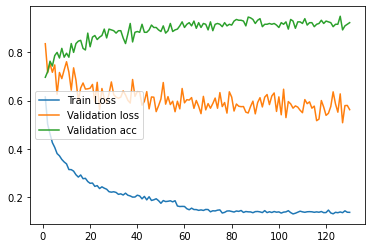

In [21]:
plt.plot(np.arange(1, len(history_train['train_loss'][0]) + 1), history_train['train_loss'][0], label = 'Train Loss')
plt.plot(np.arange(1, len(history_train['val_loss'][0]) + 1), history_train['val_loss'][0], label='Validation loss')
# plt.plot(np.arange(1, len(history_train['train_acc'][0]) + 1), history_train['train_acc'][0], label='Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][0]) + 1), history_train['val_acc'][0], label = 'Validation acc')
plt.legend()
plt.show()

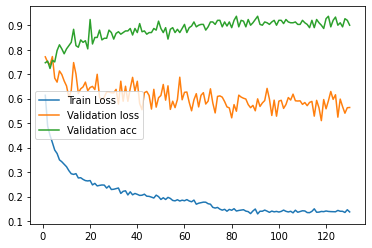

In [22]:
plt.plot(np.arange(1, len(history_train['train_loss'][1]) + 1), history_train['train_loss'][1], label = 'Train Loss')
plt.plot(np.arange(1, len(history_train['val_loss'][1]) + 1), history_train['val_loss'][1], label='Validation loss')
# plt.plot(np.arange(1, len(history_train['train_acc'][1]) + 1), history_train['train_acc'][1], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][1]) + 1), history_train['val_acc'][1], label = 'Validation acc')
plt.legend()
plt.show()

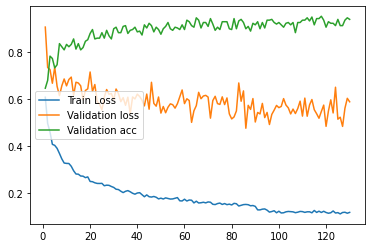

In [23]:
plt.plot(np.arange(1, len(history_train['train_loss'][2]) + 1), history_train['train_loss'][2], label = 'Train Loss')
plt.plot(np.arange(1, len(history_train['val_loss'][2]) + 1), history_train['val_loss'][2], label='Validation loss')
# plt.plot(np.arange(1, len(history_train['train_acc'][2]) + 1), history_train['train_acc'][2], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][2]) + 1), history_train['val_acc'][2], label = 'Validation acc')
plt.legend()
plt.show()

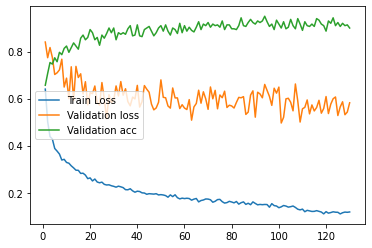

In [24]:
plt.plot(np.arange(1, len(history_train['train_loss'][3]) + 1), history_train['train_loss'][3], label = 'Train Loss')
plt.plot(np.arange(1, len(history_train['val_loss'][3]) + 1), history_train['val_loss'][3], label='Validation loss')
# plt.plot(np.arange(1, len(history_train['train_acc'][3]) + 1), history_train['train_acc'][3], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][3]) + 1), history_train['val_acc'][3], label = 'Validation acc')
plt.legend()
plt.show()

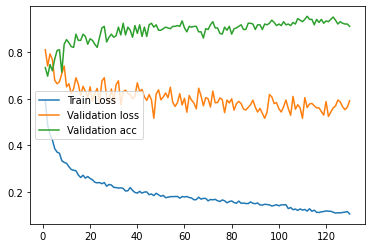

In [25]:
plt.plot(np.arange(1, len(history_train['train_loss'][4]) + 1), history_train['train_loss'][4], label = 'Train Loss')
plt.plot(np.arange(1, len(history_train['val_loss'][4]) + 1), history_train['val_loss'][4], label='Validation loss')
# plt.plot(np.arange(1, len(history_train['train_acc'][4]) + 1), history_train['train_acc'][4], label = 'Train acc')
plt.plot(np.arange(1, len(history_train['val_acc'][4]) + 1), history_train['val_acc'][4], label = 'Validation acc')
plt.legend()
plt.show()

In [212]:

import numpy as np
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from scipy import interpolate


def evaluate_lfw(distances, labels, num_folds=10, far_target=1e-3):
    """Evaluates on the Labeled Faces in the Wild dataset using KFold cross validation based on the Euclidean
    distance as a metric.
    Note: "TAR@FAR=0.001" means the rate that faces are successfully accepted (True Acceptance Rate) (TP/(TP+FN)) when
    the rate that faces are incorrectly accepted (False Acceptance Rate) (FP/(TN+FP)) is 0.001 (The less the FAR value
    the mode difficult it is for the model). i.e: 'What is the True Positive Rate of the model when only one false image
    in 1000 images is allowed?'.
        https://github.com/davidsandberg/facenet/issues/288#issuecomment-305961018
    Args:
        distances: numpy array of the pairwise distances calculated from the LFW pairs.
        labels: numpy array containing the correct result of the LFW pairs belonging to the same identity or not.
        num_folds (int): Number of folds for KFold cross-validation, defaults to 10 folds.
        far_target (float): The False Acceptance Rate to calculate the True Acceptance Rate (TAR) at,
                             defaults to 1e-3.
    Returns:
        true_positive_rate: Mean value of all true positive rates across all cross validation folds for plotting
                             the Receiver operating characteristic (ROC) curve.
        false_positive_rate: Mean value of all false positive rates across all cross validation folds for plotting
                              the Receiver operating characteristic (ROC) curve.
        accuracy: Array of accuracy values per each fold in cross validation set.
        precision: Array of precision values per each fold in cross validation set.
        recall: Array of recall values per each fold in cross validation set.
        roc_auc: Area Under the Receiver operating characteristic (AUROC) metric.
        best_distances: Array of Euclidean distance values that had the best performing accuracy on the LFW dataset
                         per each fold in cross validation set.
        tar: Array that contains True Acceptance Rate values per each fold in cross validation set
              when far (False Accept Rate) is set to a specific value.
        far: Array that contains False Acceptance Rate values per each fold in cross validation set.
    """

    # Calculate ROC metrics
    thresholds_roc = np.arange(0, 4, 0.01)
    true_positive_rate, false_positive_rate, precision, recall, accuracy, best_distances = \
        calculate_roc_values(
            thresholds=thresholds_roc, distances=distances, labels=labels, num_folds=num_folds
        )

    roc_auc = auc(false_positive_rate, true_positive_rate)

    # Calculate validation rate
    thresholds_val = np.arange(0, 4, 0.001)
    tar, far = calculate_val(
        thresholds_val=thresholds_val, distances=distances, labels=labels, far_target=far_target, num_folds=num_folds
    )

    return true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances,\
        tar, far


def calculate_roc_values(thresholds, distances, labels, num_folds=10):
    num_pairs = min(len(labels), len(distances))
    num_thresholds = len(thresholds)
    k_fold = KFold(n_splits=num_folds, shuffle=False)

    true_positive_rates = np.zeros((num_folds, num_thresholds))
    false_positive_rates = np.zeros((num_folds, num_thresholds))
    precision = np.zeros(num_folds)
    recall = np.zeros(num_folds)
    accuracy = np.zeros(num_folds)
    best_distances = np.zeros(num_folds)

    indices = np.arange(num_pairs)

    for fold_index, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the best distance threshold for the k-fold cross validation using the train set
        accuracies_trainset = np.zeros(num_thresholds)
        for threshold_index, threshold in enumerate(thresholds):
            _, _, _, _, accuracies_trainset[threshold_index] = calculate_metrics(
                threshold=threshold, 
                dist=distances[train_set], 
                actual_issame=labels[train_set]
            )
        best_threshold_index = np.argmax(accuracies_trainset)

        # Test on test set using the best distance threshold
        for threshold_index, threshold in enumerate(thresholds):
            true_positive_rates[fold_index, threshold_index], false_positive_rates[fold_index, threshold_index], _, _,\
                _ = calculate_metrics(
                    threshold=threshold, dist=distances[test_set], actual_issame=labels[test_set]
                )

        _, _, precision[fold_index], recall[fold_index], accuracy[fold_index] = calculate_metrics(
            threshold=thresholds[best_threshold_index], dist=distances[test_set], actual_issame=labels[test_set]
        )

        true_positive_rate = np.mean(true_positive_rates, 0)
        false_positive_rate = np.mean(false_positive_rates, 0)
        best_distances[fold_index] = thresholds[best_threshold_index]

    return true_positive_rate, false_positive_rate, precision, recall, accuracy, best_distances


def calculate_metrics(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else \
        float(true_positives) / float(true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else \
        float(false_positives) / float(false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else\
        float(true_positives) / float(true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else \
        float(true_positives) / float(true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    return true_positive_rate, false_positive_rate, precision, recall, accuracy


def calculate_val(thresholds_val, distances, labels, far_target=1e-3, num_folds=10):
    num_pairs = min(len(labels), len(distances))
    num_thresholds = len(thresholds_val)
    k_fold = KFold(n_splits=num_folds, shuffle=False)

    tar = np.zeros(num_folds)
    far = np.zeros(num_folds)

    indices = np.arange(num_pairs)

    for fold_index, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the euclidean distance threshold that gives false acceptance rate (far) = far_target
        far_train = np.zeros(num_thresholds)
        for threshold_index, threshold in enumerate(thresholds_val):
            _, far_train[threshold_index] = calculate_val_far(
                threshold=threshold, dist=distances[train_set], actual_issame=labels[train_set]
            )
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds_val, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        tar[fold_index], far[fold_index] = calculate_val_far(
            threshold=threshold, dist=distances[test_set], actual_issame=labels[test_set]
        )

    return tar, far


def calculate_val_far(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))

    num_same = np.sum(actual_issame)
    num_diff = np.sum(np.logical_not(actual_issame))

    if num_diff == 0:
        num_diff = 1
    if num_same == 0:
        return 0, 0

    tar = float(true_accept) / float(num_same)
    far = float(false_accept) / float(num_diff)

    return tar, far
import matplotlib.pyplot as plt
from sklearn.metrics import auc


def plot_roc_lfw(false_positive_rate, true_positive_rate, figure_name="roc.png"):
    """Plots the Receiver Operating Characteristic (ROC) curve.
    Args:
        false_positive_rate: False positive rate
        true_positive_rate: True positive rate
        figure_name (str): Name of the image file of the resulting ROC curve plot.
    """
    roc_auc = auc(false_positive_rate, true_positive_rate)
    fig = plt.figure()
    plt.plot(
        false_positive_rate, true_positive_rate, color='red', lw=2, label="ROC Curve (area = {:.4f})".format(roc_auc)
    )
    plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
#     fig.savefig(figure_name, dpi=fig.dpi)
    plt.show()
    plt.close()


def plot_accuracy_lfw(log_file, epochs, figure_name="lfw_accuracies.png"):
    """Plots the accuracies on the Labeled Faces in the Wild dataset over the training epochs.
    Args:
        log_file (str): Path of the log file containing the lfw accuracy values to be plotted.
        epochs (int): Number of training epochs finished.
        figure_name (str): Name of the image file of the resulting lfw accuracies plot.
    """
    with open(log_file, 'r') as f:
        lines = f.readlines()
        epoch_list = [int(line.split('\t')[0]) for line in lines]
        accuracy_list = [round(float(line.split('\t')[1]), 2) for line in lines]

        fig = plt.figure()
        plt.plot(epoch_list, accuracy_list, color='red', label='LFW Accuracy')
        plt.ylim([0.0, 1.05])
        plt.xlim([0, epochs + 1])
        plt.xlabel('Epoch')
        plt.ylabel('LFW Accuracy')
        plt.title('LFW Accuracies plot')
        plt.legend(loc='lower right')
        fig.savefig(figure_name, dpi=fig.dpi)
        plt.close()

In [214]:
test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                        std = [0.5, 0.5, 0.5])
    ])
# ./weights/mobile_network_120_updated20230329 020936.pth
# define batch size for testing
test_batch_size = 64
# create dataloader for validation set
val_triplet_dataset = FaceDataset(df = val_df, train = False, num_sample = 3000, transform = test_transform)
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size = test_batch_size, shuffle = True,
                                     pin_memory = True)
pd.read_csv('./csv_files/weight_records.csv').iloc[[9]]['path'].values[0]

  0%|          | 0/1473 [00:00<?, ?it/s]

'./weights/mobile_network_120_updated20230329 020936.pth'

In [62]:
latest_weight_path

'./weights/mobile_network_120_updated20230410 083255.pth'

In [224]:
# get the latest weight
latest_weight_path = get_latest_weight('./csv_files/weight_records.csv')

acc, distances, labels,loss, anch_imgs_name, test_imgs_name, test_identities, anch_identities = test_model(MobileFaceNet().to(device), val_triplet_dataloader, criterion, './weights/mobile_network_120_updated20230322 203955.pth')
print(f'Accuracy: {acc}')
predict_issame = np.less(distances, (np.full(np.size(np.array(distances)), 0.98)))

It was saved at 2023-04-10T08:32:55.047129000
Weight loaded!
Accuracy: 0.6177868295994569


In [67]:
true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=np.array(distances),
            labels=np.array(labels),
            far_target=1e-3
        )

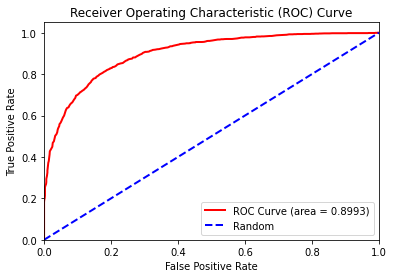

In [68]:
plot_roc_lfw(
            false_positive_rate=false_positive_rate,
            true_positive_rate=true_positive_rate,
        )

In [69]:
best_distances.min()

0.79

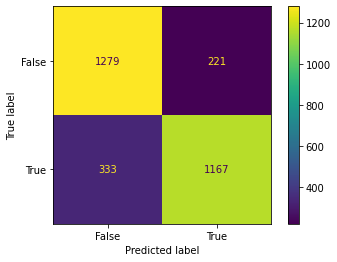

In [70]:
from sklearn import metrics
metrics.ConfusionMatrixDisplay(confusion_matrix(labels,  np.less(distances,best_distances.min()) ), display_labels = ['False', 'True']).plot()

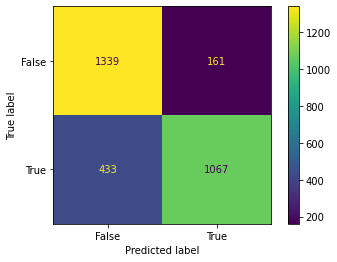

In [72]:


x =  1 / (1 + np.array(distances))
metrics.ConfusionMatrixDisplay(confusion_matrix(labels, np.less(np.full(np.size(x),0.6),x)), display_labels = ['False', 'True']).plot()

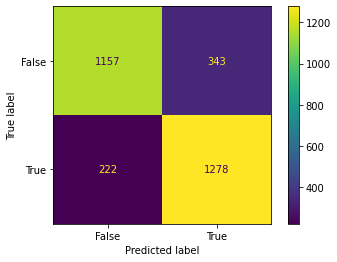

In [73]:
from sklearn import metrics
metrics.ConfusionMatrixDisplay(confusion_matrix(labels, predict_issame), display_labels = ['False', 'True']).plot()

In [14]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                        std = [0.5, 0.5, 0.5])
    ])

# define batch size for testing
test_batch_size = 64
# create dataloader for validation set
test_triplet_dataset = FaceDataset(df = test_df, train = False, num_sample = 10, transform = test_transform)
test_triplet_dataloader = DataLoader(test_triplet_dataset, batch_size = test_batch_size, shuffle = True,
                                     pin_memory = True)
# pd.read_csv('./csv_files/weight_records.csv').iloc[[9]]['path'].values[0]



  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
acc, distances, labels,loss, anch_imgs_name, test_imgs_name, test_identities, anch_identities = test_model(MobileFaceNet().to(device), test_triplet_dataloader, criterion, './weights/mobile_network_120_updated20230329 020936.pth')
print(f'Accuracy: {acc}')
predict_issame = np.less(distances, (np.full(np.size(np.array(distances)), 0.98)))

Accuracy: 1.0


In [16]:
metrics.ConfusionMatrixDisplay(confusion_matrix(labels, predict_issame), display_labels = ['False', 'True']).plot()

NameError: name 'metrics' is not defined

In [ ]:
metrics.ConfusionMatrixDisplay(confusion_matrix(labels, distances < best_distances.min()), display_labels = ['False', 'True']).plot()

In [ ]:
from sklearn import metrics
new_dist = 1 / (1+np.array(distances))
metrics.ConfusionMatrixDisplay(confusion_matrix(labels, new_dist > 0.6), display_labels = ['False', 'True']).plot()

In [37]:
predict_issame = np.less(distances, (np.full(np.size(np.array(distances)), 0.98)))

pred_df = pd.DataFrame([x for x in zip(predict_issame, labels, distances, anch_imgs_name, test_imgs_name,anch_identities, test_identities)], columns = ['pred', 'label','distance',  'anch_imgs_name', 'test_imgs_name', 'test_identities', 'anch_identities'])

false_pos_df = pred_df[(pred_df['pred'] == True) & (pred_df['label'] == False)]
false_pos_df.to_csv('sda.csv')

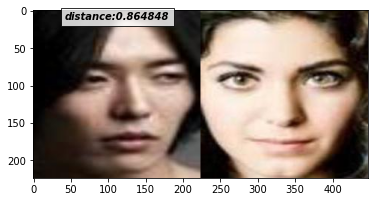

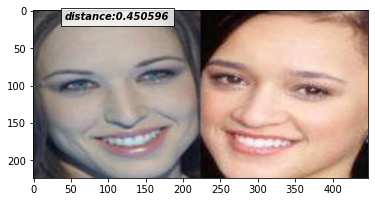

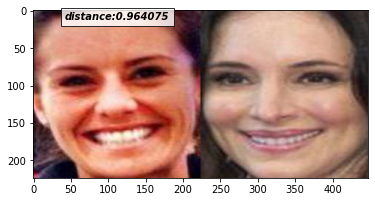

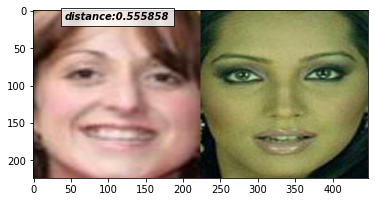

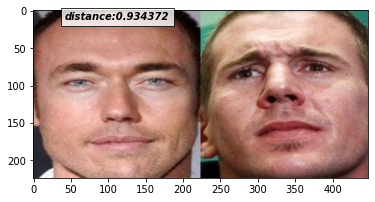

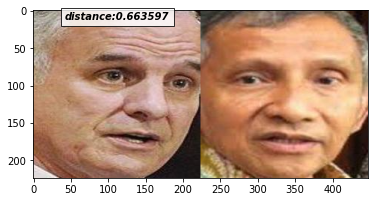

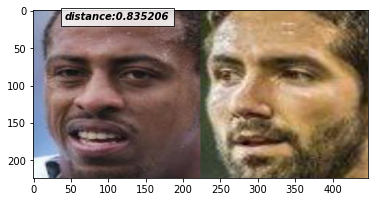

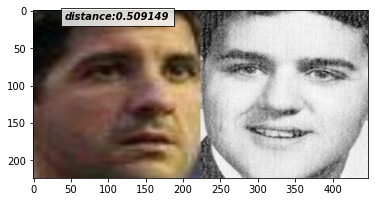

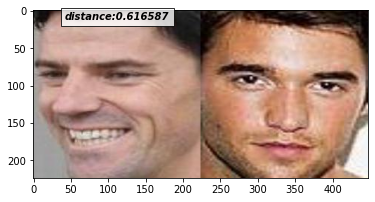

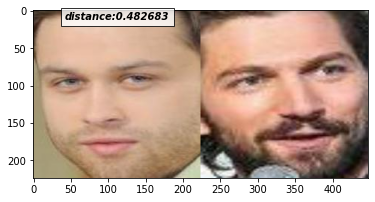

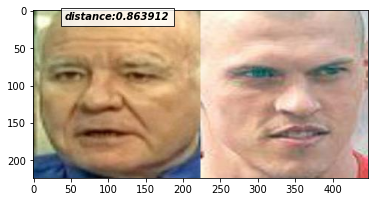

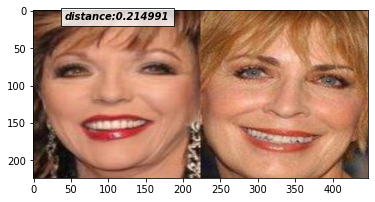

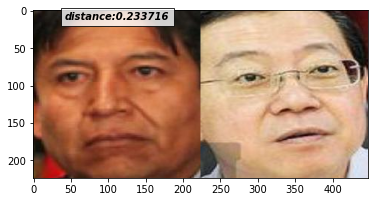

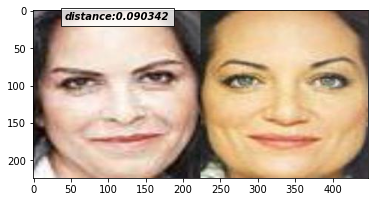

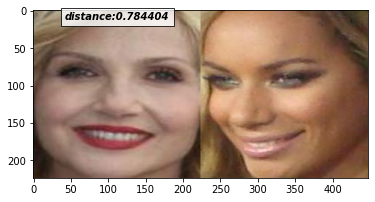

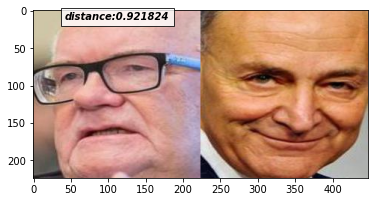

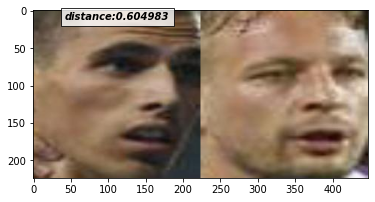

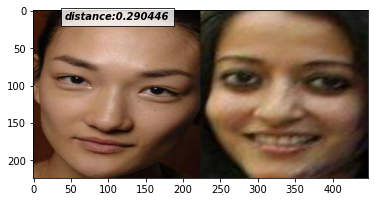

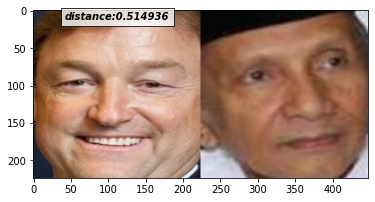

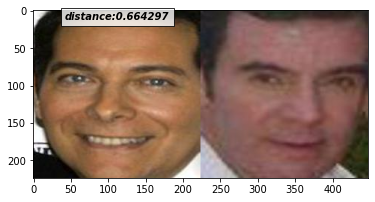

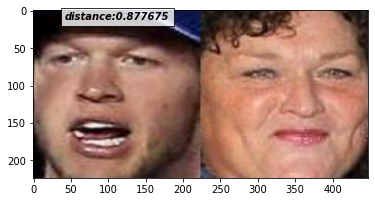

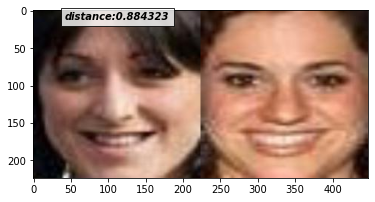

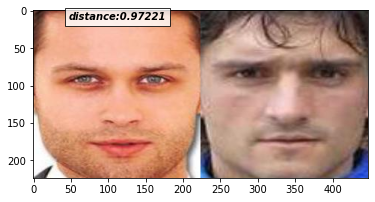

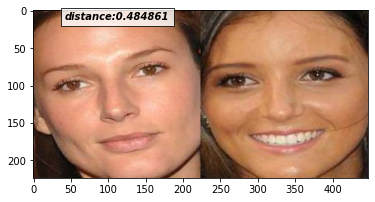

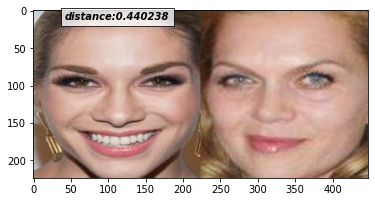

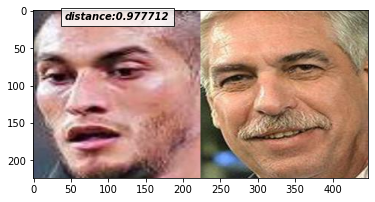

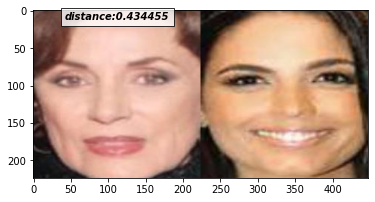

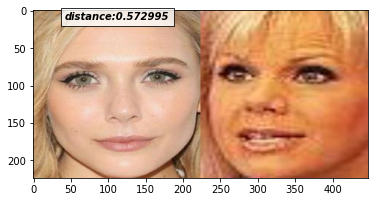

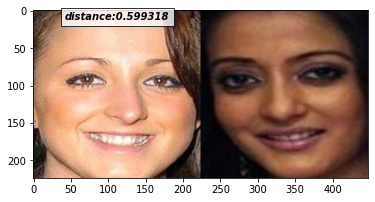

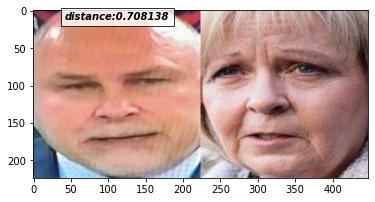

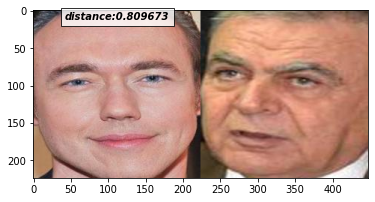

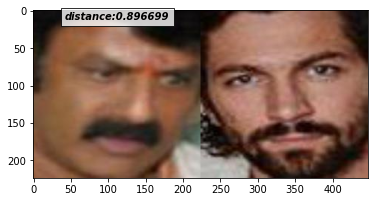

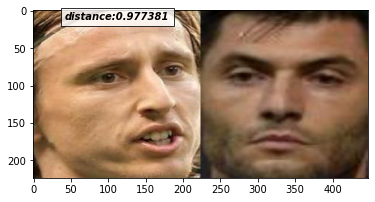

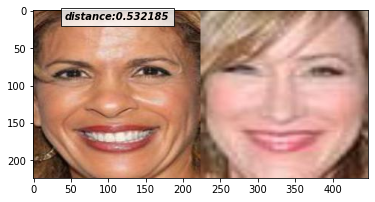

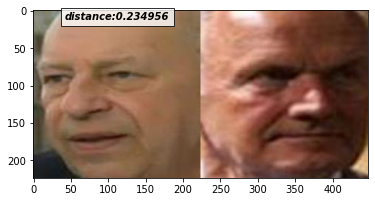

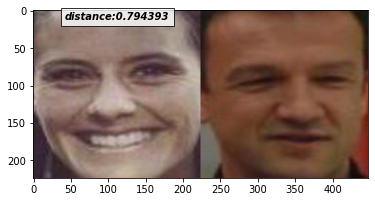

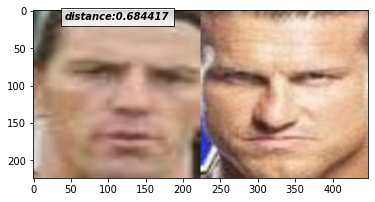

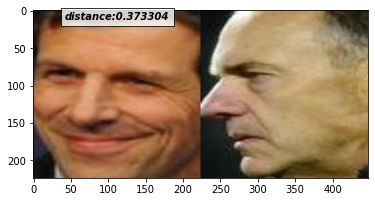

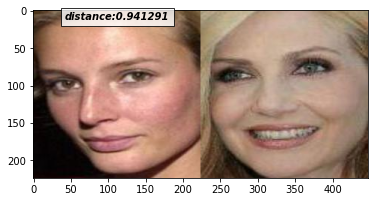

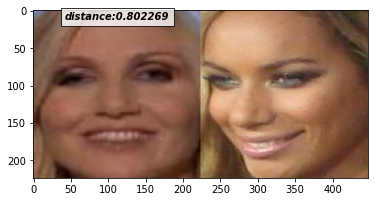

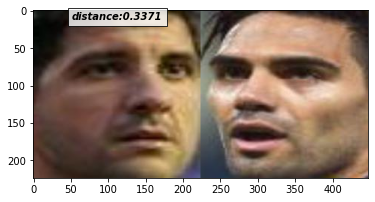

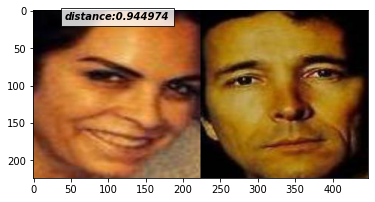

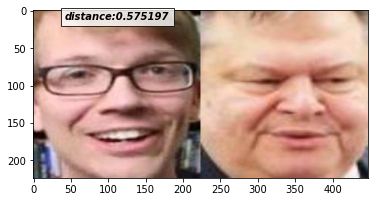

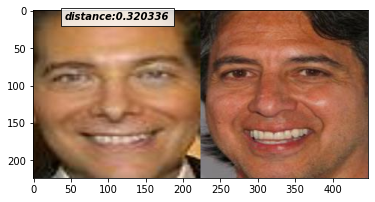

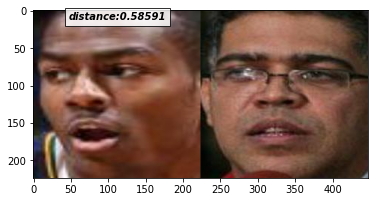

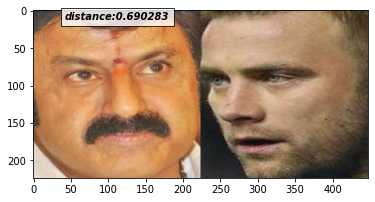

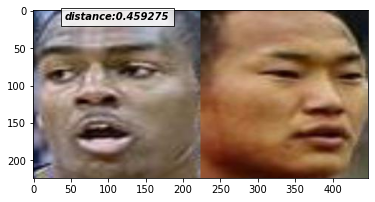

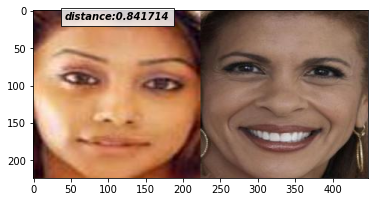

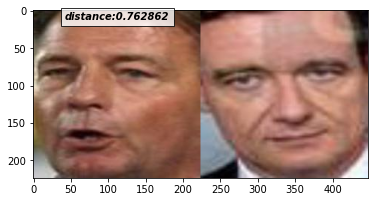

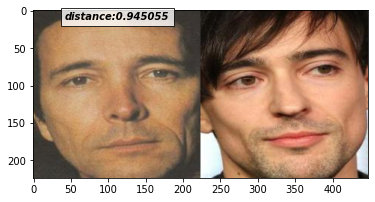

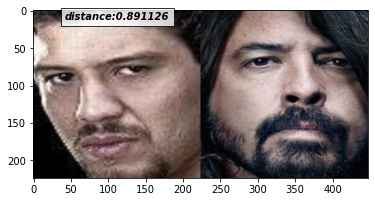

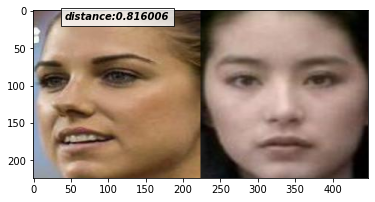

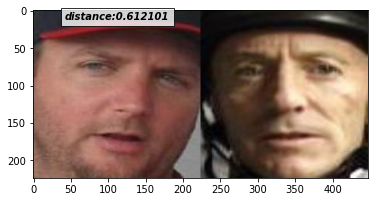

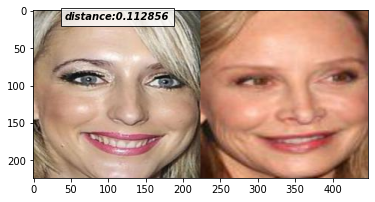

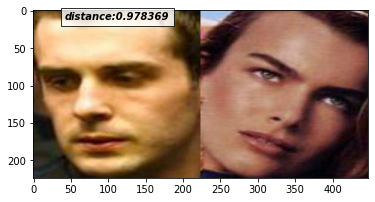

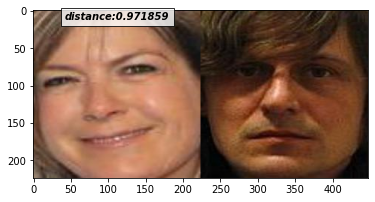

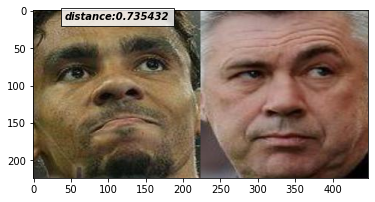

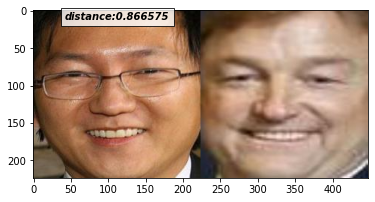

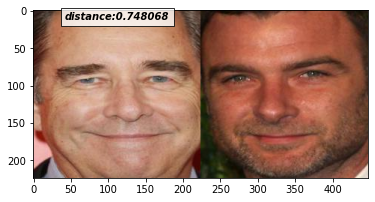

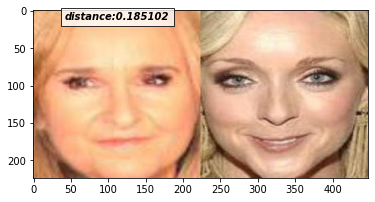

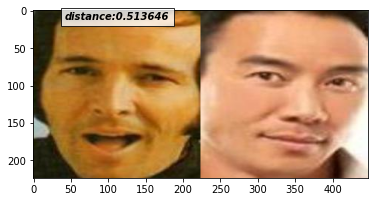

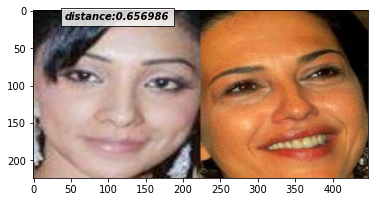

In [38]:
for _,each_row in false_pos_df.iterrows():
#     print(each_row['anch_imgs_name'])
    img1 = plt.imread(each_row['anch_imgs_name'])
    img2 = plt.imread(each_row['test_imgs_name'])
    text1 = each_row['anch_imgs_name']
    concatenated = np.concatenate([img1,img2],1)
    plt.text(112, 8, 'distance:'+ str(round(each_row['distance'],6)), style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8},ha="center", va = 'center')
    plt.imshow(concatenated)
    plt.show()